# I. Import FWR Performance report data
This data was scrapped from FWR by manager

In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, LSTM
from keras import optimizers

Using TensorFlow backend.


In [2]:
DAT = pd.read_csv("C:\\Users\\457043\\Documents\\LAXSM\\2017\\07 - JULY 17\\MGR 7 FORECAST\\LAXSM 7 Historical.csv",
                 index_col="Date", na_values="?").fillna(0)

DAT = DAT[DAT.VOL_TOT>0]
#DAT['VOL_GROWTH'] = DAT.VOL_TOT.pct_change()
DAT = DAT[1:]

DAT.head()

,FTE_HOURLY,VOL_TOT,VOL_CONS_SCAN,HR_PNWK_TOT,HR_ADMIN_TOT,DOW,MONTH,DAY,YEAR
Date,,,,,,,,,
2011-06-01,13.26,1324,1324,13.58,32.80,4,6,1,2011
2011-05-31,16.32,997,997,61.50,31.76,3,5,31,2011
2011-05-28,8.69,94,94,26.25,11.93,7,5,28,2011
2011-05-27,14.20,801,801,40.25,29.76,6,5,27,2011
2011-05-26,13.23,1012,1012,21.00,32.28,5,5,26,2011


In [3]:
DAT.describe().T

,count,mean,std,min,25%,50%,75%,max
FTE_HOURLY,2891.0,10.990688,3.769580,0.0,8.490,11.62,13.465,22.32
VOL_TOT,2891.0,888.667589,614.263111,1.0,404.500,824.00,1220.500,4978.00
VOL_CONS_SCAN,2891.0,882.645797,615.638732,0.0,395.500,820.00,1210.000,4978.00
HR_PNWK_TOT,2891.0,10.426932,10.642505,0.0,1.580,8.00,16.000,108.00
HR_ADMIN_TOT,2891.0,20.635870,12.884396,0.0,12.085,19.87,25.490,67.80
DOW,2891.0,4.505016,1.708586,1.0,3.000,4.00,6.000,7.00
MONTH,2891.0,6.347285,3.452261,1.0,3.000,6.00,9.000,12.00
DAY,2891.0,15.727430,8.723298,1.0,8.000,16.00,23.000,31.00
YEAR,2891.0,2012.222068,2.737503,2008.0,2010.000,2012.00,2015.000,2017.00


# II. Prepare Data

## Scale Data for RNN Training
Using **sklearn MinMaxScaler**

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

MIN_MAX_SCALER = MinMaxScaler()
_DATA = pd.DataFrame(MIN_MAX_SCALER.fit_transform(DAT))
#STANDARD_SCALER = StandardScaler()
#_DATA = pd.DataFrame(STANDARD_SCALER.fit_transform(DAT))
_DATA.index = DAT.index
_DATA.columns = "s" + DAT.columns
_DATA = DAT.join(_DATA)

#_DATA = _DATA[_DATA.VOL_TOT>0]
_DATA = _DATA[_DATA.index>'2015-01-01']

_DATA.head(100)

,FTE_HOURLY,VOL_TOT,VOL_CONS_SCAN,HR_PNWK_TOT,HR_ADMIN_TOT,DOW,MONTH,DAY,YEAR,sFTE_HOURLY,sVOL_TOT,sVOL_CONS_SCAN,sHR_PNWK_TOT,sHR_ADMIN_TOT,sDOW,sMONTH,sDAY,sYEAR
Date,,,,,,,,,,,,,,,,,,
2015-01-02,10.87,708,708,16.00,14.51,6,1,2,2015,0.487007,0.142053,0.142226,0.148148,0.214012,0.833333,0.000000,0.033333,0.777778
2015-01-03,7.09,18,18,10.00,13.79,7,1,3,2015,0.317652,0.003416,0.003616,0.092593,0.203392,1.000000,0.000000,0.066667,0.777778
2015-01-05,2.97,116,116,0.00,1.66,2,1,5,2015,0.133065,0.023106,0.023303,0.000000,0.024484,0.166667,0.000000,0.133333,0.777778
2015-01-06,11.51,963,963,8.00,21.52,3,1,6,2015,0.515681,0.193289,0.193451,0.074074,0.317404,0.333333,0.000000,0.166667,0.777778
2015-01-07,11.52,1517,1517,0.00,16.58,4,1,7,2015,0.516129,0.304601,0.304741,0.000000,0.244543,0.500000,0.000000,0.200000,0.777778
2015-01-08,11.73,1324,1324,1.00,16.69,5,1,8,2015,0.525538,0.265823,0.265970,0.009259,0.246165,0.666667,0.000000,0.233333,0.777778
2015-01-09,10.66,1262,1262,4.00,16.42,6,1,9,2015,0.477599,0.253365,0.253515,0.037037,0.242183,0.833333,0.000000,0.266667,0.777778
2015-01-10,8.13,133,133,12.00,18.65,7,1,10,2015,0.364247,0.026522,0.026718,0.111111,0.275074,1.000000,0.000000,0.300000,0.777778
2015-01-12,4.48,422,422,1.00,2.95,2,1,12,2015,0.200717,0.084589,0.084773,0.009259,0.043510,0.166667,0.000000,0.366667,0.777778


## Create Dummy Variables

In [5]:
_DATA = _DATA.join( pd.get_dummies(_DATA.DOW, columns=['DOW'], prefix='DOW', drop_first=True) )

_DATA = _DATA.join( pd.get_dummies(_DATA.MONTH, columns=['MONTH'], prefix='MONTH', drop_first=True) )


## Describe Data

In [6]:
_DATA.describe().T

,count,mean,std,min,25%,50%,75%,max
FTE_HOURLY,739.0,11.012517,2.737448,0.000000,10.655000,11.970000,12.635000,17.110000
VOL_TOT,739.0,894.102842,645.277899,9.000000,616.000000,826.000000,1117.500000,4763.000000
VOL_CONS_SCAN,739.0,870.545332,650.270495,0.000000,525.500000,817.000000,1099.000000,4763.000000
HR_PNWK_TOT,739.0,9.720974,10.655791,0.000000,0.000000,8.000000,16.000000,108.000000
HR_ADMIN_TOT,739.0,18.028769,6.405334,0.000000,12.850000,18.460000,23.905000,30.130000
DOW,739.0,4.504736,1.714253,1.000000,3.000000,5.000000,6.000000,7.000000
MONTH,739.0,5.859269,3.434514,1.000000,3.000000,5.000000,9.000000,12.000000
DAY,739.0,15.630582,8.711279,1.000000,8.000000,16.000000,23.000000,31.000000
YEAR,739.0,2015.788904,0.731658,2015.000000,2015.000000,2016.000000,2016.000000,2017.000000
sFTE_HOURLY,739.0,0.493392,0.122646,0.000000,0.477375,0.536290,0.566084,0.766577


## Select Predictors

In [7]:
lookback_predictors = 90
horizon = 60
timesteps = 60

OPERATION = 'LAXSM-7'

#PREDICTORS = ['sVOL_TOT','sDOW','sMONTH','sDAY']
#PREDICTORS = ['sVOL_TOT']
PREDICTORS = ['sVOL_TOT','sDAY',
              'DOW_2','DOW_3','DOW_4','DOW_5','DOW_6','DOW_7',
              'MONTH_2','MONTH_3','MONTH_4','MONTH_5','MONTH_6','MONTH_7',
              'MONTH_8','MONTH_9','MONTH_10','MONTH_11','MONTH_12']
#PREDICTORS = ['VOL_TOT','DOW']

TARGET = ['sVOL_TOT']

# III. Split Data into Training and Testing

In [8]:
TRAIN = _DATA.iloc[:-(lookback_predictors + horizon + timesteps)]
TEST = _DATA.iloc[-(lookback_predictors + horizon + timesteps):]

## Create Testing Data Set

In [9]:
TEST_X = []
TEST_Y = []

for i in range( TEST.shape[0] -(lookback_predictors + horizon ) ):
    TEST_X.append( np.array(TEST.iloc[i:i + lookback_predictors][PREDICTORS].T ) )
    TEST_Y.append( np.array(TEST.iloc[i + lookback_predictors:i + lookback_predictors + horizon ][TARGET].T ) )
    
TEST_X = np.array(TEST_X)
#TEST_X = TEST_X.reshape(TEST_X.shape[0], 1, lookback_predictors * TEST_X.shape[1])
TEST_X = TEST_X.reshape(1, timesteps, lookback_predictors * TEST_X.shape[1])


TEST_Y = np.array(TEST_Y)
#TEST_Y = TEST_Y.reshape(TEST_Y.shape[0], 1, horizon * TEST_Y.shape[1])
TEST_Y = TEST_Y.reshape(1, timesteps, horizon * TEST_Y.shape[1])

TEST_X.shape

(1, 60, 1710)

## Create Training Data Set

In [10]:
TRAIN_X = []
TRAIN_Y = []

for i in range( int((TRAIN.shape[0] -(lookback_predictors + horizon) + 1) / timesteps) * timesteps ):
    TRAIN_X.append( np.array(TRAIN.iloc[i:i + lookback_predictors][PREDICTORS].T ) )
    TRAIN_Y.append( np.array(TRAIN.iloc[i + lookback_predictors:i + lookback_predictors + horizon ][TARGET].T ) )
    
    
TRAIN_X = np.array(TRAIN_X)
#TRAIN_X = TRAIN_X.reshape(TRAIN_X.shape[0], 1, lookback_predictors * TRAIN_X.shape[1])
TRAIN_X = TRAIN_X.reshape(int(TRAIN_X.shape[0]/timesteps), timesteps, lookback_predictors * TRAIN_X.shape[1])


TRAIN_Y = np.array(TRAIN_Y)
#TRAIN_Y = TRAIN_Y.reshape(TRAIN_Y.shape[0], 1, horizon * TRAIN_Y.shape[1] )
TRAIN_Y = TRAIN_Y.reshape(int(TRAIN_Y.shape[0]/timesteps), timesteps, horizon * TRAIN_Y.shape[1] )

TRAIN_X.shape

(6, 60, 1710)

# IV. Build RNN Model
Number of hidden nodes: There is no magic formula for selecting the optimum number of hidden neurons. However, some thumb rules are available for calculating number of hidden neurons. A rough approximation can be obtained by the geometric pyramid rule proposed by Masters (1993). For a three layer network with n input and m output neurons, the hidden layer would have sqrt(n∗m) neurons.

Ref:

[1] Masters, Timothy. Practical neural network recipes in C++. Morgan Kaufmann, 1993.

[2] http://www.iitbhu.ac.in/faculty/min/rajesh-rai/NMEICT-Slope/lecture/c14/l1.html

In [24]:
hidden_size = int(np.sqrt(TRAIN_X.shape[2] * TRAIN_Y.shape[2]))
hidden_size

320

In [25]:
# Build Model
model = Sequential()  
model.add(LSTM(hidden_size, return_sequences=True, activation='tanh', dropout=0.2, name='GRU_1', 
               #stateful=True, batch_size=TRAIN_X.shape[0] ,
               input_shape=(TRAIN_X.shape[1], TRAIN_X.shape[2]) ) )
#model.add(LSTM(hidden_size, return_sequences=True, activation='relu', dropout=0.1, name='GRU_2'))
#model.add(LSTM(hidden_size + 10, return_sequences=True, activation='relu', dropout=0.1, name='GRU_3'))
#model.add(LSTM(hidden_size, return_sequences=True, activation='relu', name='GRU_4'))
#model.add(LSTM(horizon, return_sequences=True, activation='relu', name='GRU_OUT'))
model.add(Dense(horizon, activation='relu', name="Dense_OUT"))

## Load Model
From saved HDF5 file for training with new data.  Commented for initial training.

In [92]:
from keras.models import load_model
model = load_model('{}_MODEL.h5'.format(OPERATION))

## Train, and Save the RNN

In [93]:
# set optimizer
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)
adagrad = optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
nadam = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)


model.compile(loss='mse', optimizer=nadam, metrics=['mae'])



for i in range(5):
    # counter
    print("\n\n*****************\nIteration {}\n*****************\n".format(i))
    
    # train rnn
    model.fit(TRAIN_X, TRAIN_Y, epochs=1000, verbose=True, 
              #validation_data=(TEST_X, TEST_Y) 
              validation_split=0.2, validation_data=(TRAIN_X, TRAIN_Y)
             )
    
    # save rnn
    model.save('{}_MODEL.h5'.format(OPERATION), overwrite=True)  # Save RNN to HDF5 file 'OPERATION_MODEL.h5'



*****************
Iteration 0
*****************

Train on 6 samples, validate on 6 samples
Epoch 1/1000
6/6 [==============================] - 2s - loss: 1.7314e-05 - mean_absolute_error: 0.0030 - val_loss: 2.1090e-04 - val_mean_absolute_error: 0.0115
Epoch 2/1000
6/6 [==============================] - 0s - loss: 2.1176e-04 - mean_absolute_error: 0.0115 - val_loss: 3.7551e-05 - val_mean_absolute_error: 0.0047
Epoch 3/1000
6/6 [==============================] - 0s - loss: 4.3093e-05 - mean_absolute_error: 0.0050 - val_loss: 2.4578e-05 - val_mean_absolute_error: 0.0037
Epoch 4/1000
6/6 [==============================] - 0s - loss: 2.8791e-05 - mean_absolute_error: 0.0040 - val_loss: 2.5263e-05 - val_mean_absolute_error: 0.0037
Epoch 5/1000
6/6 [==============================] - 0s - loss: 3.0553e-05 - mean_absolute_error: 0.0042 - val_loss: 2.6874e-05 - val_mean_absolute_error: 0.0039
Epoch 6/1000
6/6 [==============================] - 0s - loss: 3.0797e-05 - mean_absolute_error: 0.004

6/6 [==============================] - 0s - loss: 4.3243e-05 - mean_absolute_error: 0.0050 - val_loss: 3.4386e-05 - val_mean_absolute_error: 0.0045
Epoch 52/1000
6/6 [==============================] - 0s - loss: 3.7507e-05 - mean_absolute_error: 0.0047 - val_loss: 3.1887e-05 - val_mean_absolute_error: 0.0043
Epoch 53/1000
6/6 [==============================] - 0s - loss: 3.7483e-05 - mean_absolute_error: 0.0047 - val_loss: 3.2202e-05 - val_mean_absolute_error: 0.0043
Epoch 54/1000
6/6 [==============================] - 0s - loss: 3.6034e-05 - mean_absolute_error: 0.0045 - val_loss: 3.2436e-05 - val_mean_absolute_error: 0.0043
Epoch 55/1000
6/6 [==============================] - 0s - loss: 3.6457e-05 - mean_absolute_error: 0.0046 - val_loss: 3.3111e-05 - val_mean_absolute_error: 0.0043
Epoch 56/1000
6/6 [==============================] - 0s - loss: 3.7136e-05 - mean_absolute_error: 0.0046 - val_loss: 3.5499e-05 - val_mean_absolute_error: 0.0045
Epoch 57/1000
6/6 [=======================

6/6 [==============================] - 0s - loss: 4.9905e-05 - mean_absolute_error: 0.0054 - val_loss: 4.5173e-05 - val_mean_absolute_error: 0.0051
Epoch 102/1000
6/6 [==============================] - 0s - loss: 4.8959e-05 - mean_absolute_error: 0.0053 - val_loss: 4.1410e-05 - val_mean_absolute_error: 0.0049
Epoch 103/1000
6/6 [==============================] - 0s - loss: 4.7167e-05 - mean_absolute_error: 0.0053 - val_loss: 4.4224e-05 - val_mean_absolute_error: 0.0051
Epoch 104/1000
6/6 [==============================] - 0s - loss: 5.1512e-05 - mean_absolute_error: 0.0055 - val_loss: 4.6204e-05 - val_mean_absolute_error: 0.0052
Epoch 105/1000
6/6 [==============================] - 0s - loss: 5.0868e-05 - mean_absolute_error: 0.0055 - val_loss: 4.7596e-05 - val_mean_absolute_error: 0.0052
Epoch 106/1000
6/6 [==============================] - 0s - loss: 5.1668e-05 - mean_absolute_error: 0.0055 - val_loss: 4.3012e-05 - val_mean_absolute_error: 0.0050
Epoch 107/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 4.1215e-05 - mean_absolute_error: 0.0049 - val_loss: 3.8581e-05 - val_mean_absolute_error: 0.0047
Epoch 152/1000
6/6 [==============================] - 0s - loss: 4.3049e-05 - mean_absolute_error: 0.0049 - val_loss: 3.8534e-05 - val_mean_absolute_error: 0.0047
Epoch 153/1000
6/6 [==============================] - 0s - loss: 4.4599e-05 - mean_absolute_error: 0.0051 - val_loss: 4.1212e-05 - val_mean_absolute_error: 0.0048
Epoch 154/1000
6/6 [==============================] - 0s - loss: 4.7553e-05 - mean_absolute_error: 0.0052 - val_loss: 4.2223e-05 - val_mean_absolute_error: 0.0050
Epoch 155/1000
6/6 [==============================] - 0s - loss: 4.7016e-05 - mean_absolute_error: 0.0053 - val_loss: 4.4037e-05 - val_mean_absolute_error: 0.0051
Epoch 156/1000
6/6 [==============================] - 0s - loss: 4.8995e-05 - mean_absolute_error: 0.0053 - val_loss: 4.1489e-05 - val_mean_absolute_error: 0.0049
Epoch 157/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 4.3960e-05 - mean_absolute_error: 0.0051 - val_loss: 3.4123e-05 - val_mean_absolute_error: 0.0045
Epoch 202/1000
6/6 [==============================] - 0s - loss: 4.0715e-05 - mean_absolute_error: 0.0049 - val_loss: 3.5592e-05 - val_mean_absolute_error: 0.0045
Epoch 203/1000
6/6 [==============================] - 0s - loss: 4.0005e-05 - mean_absolute_error: 0.0048 - val_loss: 3.2475e-05 - val_mean_absolute_error: 0.0043
Epoch 204/1000
6/6 [==============================] - 0s - loss: 3.6993e-05 - mean_absolute_error: 0.0046 - val_loss: 3.1799e-05 - val_mean_absolute_error: 0.0042
Epoch 205/1000
6/6 [==============================] - 0s - loss: 3.7926e-05 - mean_absolute_error: 0.0047 - val_loss: 3.2889e-05 - val_mean_absolute_error: 0.0044
Epoch 206/1000
6/6 [==============================] - 0s - loss: 3.6374e-05 - mean_absolute_error: 0.0046 - val_loss: 3.0559e-05 - val_mean_absolute_error: 0.0042
Epoch 207/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 4.7866e-05 - mean_absolute_error: 0.0053 - val_loss: 4.6844e-05 - val_mean_absolute_error: 0.0052
Epoch 252/1000
6/6 [==============================] - 0s - loss: 5.2846e-05 - mean_absolute_error: 0.0055 - val_loss: 4.8177e-05 - val_mean_absolute_error: 0.0053
Epoch 253/1000
6/6 [==============================] - 0s - loss: 5.2681e-05 - mean_absolute_error: 0.0055 - val_loss: 4.8353e-05 - val_mean_absolute_error: 0.0053
Epoch 254/1000
6/6 [==============================] - 0s - loss: 5.4942e-05 - mean_absolute_error: 0.0056 - val_loss: 4.8757e-05 - val_mean_absolute_error: 0.0053
Epoch 255/1000
6/6 [==============================] - 0s - loss: 5.5000e-05 - mean_absolute_error: 0.0057 - val_loss: 5.2856e-05 - val_mean_absolute_error: 0.0055
Epoch 256/1000
6/6 [==============================] - 0s - loss: 5.9581e-05 - mean_absolute_error: 0.0058 - val_loss: 5.0664e-05 - val_mean_absolute_error: 0.0054
Epoch 257/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 3.7815e-05 - mean_absolute_error: 0.0046 - val_loss: 3.1711e-05 - val_mean_absolute_error: 0.0042
Epoch 302/1000
6/6 [==============================] - 0s - loss: 3.5891e-05 - mean_absolute_error: 0.0045 - val_loss: 3.1580e-05 - val_mean_absolute_error: 0.0042
Epoch 303/1000
6/6 [==============================] - 0s - loss: 3.6357e-05 - mean_absolute_error: 0.0046 - val_loss: 3.0714e-05 - val_mean_absolute_error: 0.0041
Epoch 304/1000
6/6 [==============================] - 0s - loss: 3.5913e-05 - mean_absolute_error: 0.0045 - val_loss: 3.2771e-05 - val_mean_absolute_error: 0.0043
Epoch 305/1000
6/6 [==============================] - 0s - loss: 3.7912e-05 - mean_absolute_error: 0.0047 - val_loss: 3.3001e-05 - val_mean_absolute_error: 0.0044
Epoch 306/1000
6/6 [==============================] - 0s - loss: 3.8406e-05 - mean_absolute_error: 0.0047 - val_loss: 3.4552e-05 - val_mean_absolute_error: 0.0044
Epoch 307/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 3.4953e-05 - mean_absolute_error: 0.0045 - val_loss: 3.0304e-05 - val_mean_absolute_error: 0.0041
Epoch 352/1000
6/6 [==============================] - 0s - loss: 3.5255e-05 - mean_absolute_error: 0.0045 - val_loss: 3.0821e-05 - val_mean_absolute_error: 0.0041
Epoch 353/1000
6/6 [==============================] - 0s - loss: 3.6646e-05 - mean_absolute_error: 0.0046 - val_loss: 3.2366e-05 - val_mean_absolute_error: 0.0043
Epoch 354/1000
6/6 [==============================] - 0s - loss: 3.7223e-05 - mean_absolute_error: 0.0046 - val_loss: 3.2122e-05 - val_mean_absolute_error: 0.0042
Epoch 355/1000
6/6 [==============================] - 0s - loss: 3.6153e-05 - mean_absolute_error: 0.0045 - val_loss: 3.1229e-05 - val_mean_absolute_error: 0.0042
Epoch 356/1000
6/6 [==============================] - 0s - loss: 3.6296e-05 - mean_absolute_error: 0.0046 - val_loss: 3.0806e-05 - val_mean_absolute_error: 0.0041
Epoch 357/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 3.8782e-05 - mean_absolute_error: 0.0047 - val_loss: 3.3017e-05 - val_mean_absolute_error: 0.0043
Epoch 402/1000
6/6 [==============================] - 0s - loss: 3.7814e-05 - mean_absolute_error: 0.0047 - val_loss: 3.2886e-05 - val_mean_absolute_error: 0.0043
Epoch 403/1000
6/6 [==============================] - 0s - loss: 3.8772e-05 - mean_absolute_error: 0.0047 - val_loss: 3.3071e-05 - val_mean_absolute_error: 0.0043
Epoch 404/1000
6/6 [==============================] - 0s - loss: 3.7840e-05 - mean_absolute_error: 0.0047 - val_loss: 3.3031e-05 - val_mean_absolute_error: 0.0043
Epoch 405/1000
6/6 [==============================] - 0s - loss: 3.9175e-05 - mean_absolute_error: 0.0047 - val_loss: 3.5245e-05 - val_mean_absolute_error: 0.0045
Epoch 406/1000
6/6 [==============================] - 0s - loss: 4.0076e-05 - mean_absolute_error: 0.0048 - val_loss: 3.5485e-05 - val_mean_absolute_error: 0.0045
Epoch 407/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 3.5532e-05 - mean_absolute_error: 0.0045 - val_loss: 3.1183e-05 - val_mean_absolute_error: 0.0042
Epoch 452/1000
6/6 [==============================] - 0s - loss: 3.6904e-05 - mean_absolute_error: 0.0046 - val_loss: 3.1369e-05 - val_mean_absolute_error: 0.0042
Epoch 453/1000
6/6 [==============================] - 0s - loss: 3.6849e-05 - mean_absolute_error: 0.0046 - val_loss: 3.1722e-05 - val_mean_absolute_error: 0.0042
Epoch 454/1000
6/6 [==============================] - 0s - loss: 3.8314e-05 - mean_absolute_error: 0.0047 - val_loss: 3.1692e-05 - val_mean_absolute_error: 0.0042
Epoch 455/1000
6/6 [==============================] - 0s - loss: 3.6081e-05 - mean_absolute_error: 0.0045 - val_loss: 3.0550e-05 - val_mean_absolute_error: 0.0041
Epoch 456/1000
6/6 [==============================] - 0s - loss: 3.6926e-05 - mean_absolute_error: 0.0046 - val_loss: 3.2673e-05 - val_mean_absolute_error: 0.0043
Epoch 457/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 3.0529e-05 - mean_absolute_error: 0.0041 - val_loss: 2.7170e-05 - val_mean_absolute_error: 0.0039
Epoch 502/1000
6/6 [==============================] - 0s - loss: 3.1182e-05 - mean_absolute_error: 0.0042 - val_loss: 2.5111e-05 - val_mean_absolute_error: 0.0037
Epoch 503/1000
6/6 [==============================] - 0s - loss: 3.0096e-05 - mean_absolute_error: 0.0041 - val_loss: 2.5822e-05 - val_mean_absolute_error: 0.0038
Epoch 504/1000
6/6 [==============================] - 0s - loss: 3.1145e-05 - mean_absolute_error: 0.0042 - val_loss: 2.6089e-05 - val_mean_absolute_error: 0.0038
Epoch 505/1000
6/6 [==============================] - 0s - loss: 3.1770e-05 - mean_absolute_error: 0.0043 - val_loss: 2.8513e-05 - val_mean_absolute_error: 0.0040
Epoch 506/1000
6/6 [==============================] - 0s - loss: 3.4265e-05 - mean_absolute_error: 0.0044 - val_loss: 2.8410e-05 - val_mean_absolute_error: 0.0040
Epoch 507/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 3.4126e-05 - mean_absolute_error: 0.0044 - val_loss: 3.1123e-05 - val_mean_absolute_error: 0.0041
Epoch 552/1000
6/6 [==============================] - 0s - loss: 3.5803e-05 - mean_absolute_error: 0.0045 - val_loss: 2.8878e-05 - val_mean_absolute_error: 0.0040
Epoch 553/1000
6/6 [==============================] - 0s - loss: 3.3536e-05 - mean_absolute_error: 0.0044 - val_loss: 2.8645e-05 - val_mean_absolute_error: 0.0040
Epoch 554/1000
6/6 [==============================] - 0s - loss: 3.3414e-05 - mean_absolute_error: 0.0044 - val_loss: 2.6523e-05 - val_mean_absolute_error: 0.0038
Epoch 555/1000
6/6 [==============================] - 0s - loss: 3.1445e-05 - mean_absolute_error: 0.0042 - val_loss: 2.7363e-05 - val_mean_absolute_error: 0.0039
Epoch 556/1000
6/6 [==============================] - 0s - loss: 3.1735e-05 - mean_absolute_error: 0.0042 - val_loss: 2.4900e-05 - val_mean_absolute_error: 0.0037
Epoch 557/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 3.8014e-05 - mean_absolute_error: 0.0046 - val_loss: 3.2530e-05 - val_mean_absolute_error: 0.0042
Epoch 602/1000
6/6 [==============================] - 0s - loss: 3.7480e-05 - mean_absolute_error: 0.0046 - val_loss: 3.2439e-05 - val_mean_absolute_error: 0.0043
Epoch 603/1000
6/6 [==============================] - 0s - loss: 3.8574e-05 - mean_absolute_error: 0.0047 - val_loss: 3.2213e-05 - val_mean_absolute_error: 0.0042
Epoch 604/1000
6/6 [==============================] - 0s - loss: 3.7906e-05 - mean_absolute_error: 0.0046 - val_loss: 3.2819e-05 - val_mean_absolute_error: 0.0042
Epoch 605/1000
6/6 [==============================] - 0s - loss: 3.8238e-05 - mean_absolute_error: 0.0046 - val_loss: 3.1548e-05 - val_mean_absolute_error: 0.0041
Epoch 606/1000
6/6 [==============================] - 0s - loss: 3.6722e-05 - mean_absolute_error: 0.0045 - val_loss: 3.1052e-05 - val_mean_absolute_error: 0.0041
Epoch 607/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 3.5016e-05 - mean_absolute_error: 0.0045 - val_loss: 2.9833e-05 - val_mean_absolute_error: 0.0041
Epoch 652/1000
6/6 [==============================] - 0s - loss: 3.5267e-05 - mean_absolute_error: 0.0045 - val_loss: 2.7817e-05 - val_mean_absolute_error: 0.0039
Epoch 653/1000
6/6 [==============================] - 0s - loss: 3.3415e-05 - mean_absolute_error: 0.0043 - val_loss: 3.0708e-05 - val_mean_absolute_error: 0.0041
Epoch 654/1000
6/6 [==============================] - 0s - loss: 3.4342e-05 - mean_absolute_error: 0.0044 - val_loss: 2.5738e-05 - val_mean_absolute_error: 0.0038
Epoch 655/1000
6/6 [==============================] - 0s - loss: 3.0925e-05 - mean_absolute_error: 0.0042 - val_loss: 2.6859e-05 - val_mean_absolute_error: 0.0038
Epoch 656/1000
6/6 [==============================] - 0s - loss: 3.3198e-05 - mean_absolute_error: 0.0043 - val_loss: 2.6841e-05 - val_mean_absolute_error: 0.0038
Epoch 657/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 2.8128e-05 - mean_absolute_error: 0.0040 - val_loss: 2.2799e-05 - val_mean_absolute_error: 0.0035
Epoch 702/1000
6/6 [==============================] - 0s - loss: 2.8134e-05 - mean_absolute_error: 0.0040 - val_loss: 2.2558e-05 - val_mean_absolute_error: 0.0035
Epoch 703/1000
6/6 [==============================] - 0s - loss: 2.7579e-05 - mean_absolute_error: 0.0040 - val_loss: 2.2421e-05 - val_mean_absolute_error: 0.0035
Epoch 704/1000
6/6 [==============================] - 0s - loss: 2.7908e-05 - mean_absolute_error: 0.0040 - val_loss: 2.3948e-05 - val_mean_absolute_error: 0.0036
Epoch 705/1000
6/6 [==============================] - 0s - loss: 2.9780e-05 - mean_absolute_error: 0.0041 - val_loss: 2.5730e-05 - val_mean_absolute_error: 0.0038
Epoch 706/1000
6/6 [==============================] - 0s - loss: 3.0596e-05 - mean_absolute_error: 0.0042 - val_loss: 2.6911e-05 - val_mean_absolute_error: 0.0039
Epoch 707/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 3.2993e-05 - mean_absolute_error: 0.0043 - val_loss: 2.9126e-05 - val_mean_absolute_error: 0.0040
Epoch 752/1000
6/6 [==============================] - 0s - loss: 3.3320e-05 - mean_absolute_error: 0.0044 - val_loss: 2.8396e-05 - val_mean_absolute_error: 0.0040
Epoch 753/1000
6/6 [==============================] - 0s - loss: 3.2392e-05 - mean_absolute_error: 0.0043 - val_loss: 2.5717e-05 - val_mean_absolute_error: 0.0038
Epoch 754/1000
6/6 [==============================] - 0s - loss: 3.0719e-05 - mean_absolute_error: 0.0042 - val_loss: 2.4678e-05 - val_mean_absolute_error: 0.0037
Epoch 755/1000
6/6 [==============================] - 0s - loss: 3.0558e-05 - mean_absolute_error: 0.0041 - val_loss: 2.5474e-05 - val_mean_absolute_error: 0.0037
Epoch 756/1000
6/6 [==============================] - 0s - loss: 3.1503e-05 - mean_absolute_error: 0.0042 - val_loss: 2.7418e-05 - val_mean_absolute_error: 0.0039
Epoch 757/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 3.7375e-05 - mean_absolute_error: 0.0047 - val_loss: 3.2457e-05 - val_mean_absolute_error: 0.0043
Epoch 802/1000
6/6 [==============================] - 0s - loss: 3.7252e-05 - mean_absolute_error: 0.0046 - val_loss: 2.9350e-05 - val_mean_absolute_error: 0.0041
Epoch 803/1000
6/6 [==============================] - 0s - loss: 3.3170e-05 - mean_absolute_error: 0.0044 - val_loss: 2.7852e-05 - val_mean_absolute_error: 0.0040
Epoch 804/1000
6/6 [==============================] - 0s - loss: 3.2574e-05 - mean_absolute_error: 0.0043 - val_loss: 2.6663e-05 - val_mean_absolute_error: 0.0039
Epoch 805/1000
6/6 [==============================] - 0s - loss: 3.2790e-05 - mean_absolute_error: 0.0043 - val_loss: 3.0377e-05 - val_mean_absolute_error: 0.0042
Epoch 806/1000
6/6 [==============================] - 0s - loss: 3.6762e-05 - mean_absolute_error: 0.0046 - val_loss: 3.1455e-05 - val_mean_absolute_error: 0.0042
Epoch 807/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 3.9018e-05 - mean_absolute_error: 0.0047 - val_loss: 3.5157e-05 - val_mean_absolute_error: 0.0044
Epoch 852/1000
6/6 [==============================] - 0s - loss: 3.9557e-05 - mean_absolute_error: 0.0047 - val_loss: 3.2313e-05 - val_mean_absolute_error: 0.0042
Epoch 853/1000
6/6 [==============================] - 0s - loss: 3.6603e-05 - mean_absolute_error: 0.0046 - val_loss: 3.0210e-05 - val_mean_absolute_error: 0.0041
Epoch 854/1000
6/6 [==============================] - 0s - loss: 3.6912e-05 - mean_absolute_error: 0.0046 - val_loss: 3.2167e-05 - val_mean_absolute_error: 0.0042
Epoch 855/1000
6/6 [==============================] - 0s - loss: 3.7575e-05 - mean_absolute_error: 0.0046 - val_loss: 3.2501e-05 - val_mean_absolute_error: 0.0043
Epoch 856/1000
6/6 [==============================] - 0s - loss: 3.7056e-05 - mean_absolute_error: 0.0046 - val_loss: 2.9483e-05 - val_mean_absolute_error: 0.0041
Epoch 857/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 3.3605e-05 - mean_absolute_error: 0.0044 - val_loss: 2.8665e-05 - val_mean_absolute_error: 0.0040
Epoch 902/1000
6/6 [==============================] - 0s - loss: 3.2415e-05 - mean_absolute_error: 0.0043 - val_loss: 2.5817e-05 - val_mean_absolute_error: 0.0038
Epoch 903/1000
6/6 [==============================] - 0s - loss: 3.0593e-05 - mean_absolute_error: 0.0042 - val_loss: 2.3858e-05 - val_mean_absolute_error: 0.0036
Epoch 904/1000
6/6 [==============================] - 0s - loss: 2.9144e-05 - mean_absolute_error: 0.0041 - val_loss: 2.4501e-05 - val_mean_absolute_error: 0.0037
Epoch 905/1000
6/6 [==============================] - 0s - loss: 2.8544e-05 - mean_absolute_error: 0.0040 - val_loss: 2.2405e-05 - val_mean_absolute_error: 0.0035
Epoch 906/1000
6/6 [==============================] - 0s - loss: 2.7727e-05 - mean_absolute_error: 0.0040 - val_loss: 2.3387e-05 - val_mean_absolute_error: 0.0036
Epoch 907/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 3.0556e-05 - mean_absolute_error: 0.0042 - val_loss: 2.6017e-05 - val_mean_absolute_error: 0.0038
Epoch 952/1000
6/6 [==============================] - 0s - loss: 3.0939e-05 - mean_absolute_error: 0.0042 - val_loss: 2.4573e-05 - val_mean_absolute_error: 0.0037
Epoch 953/1000
6/6 [==============================] - 0s - loss: 2.8229e-05 - mean_absolute_error: 0.0040 - val_loss: 2.2536e-05 - val_mean_absolute_error: 0.0035
Epoch 954/1000
6/6 [==============================] - 0s - loss: 2.8022e-05 - mean_absolute_error: 0.0040 - val_loss: 2.2355e-05 - val_mean_absolute_error: 0.0035
Epoch 955/1000
6/6 [==============================] - 0s - loss: 2.7278e-05 - mean_absolute_error: 0.0039 - val_loss: 2.3057e-05 - val_mean_absolute_error: 0.0036
Epoch 956/1000
6/6 [==============================] - 0s - loss: 2.8402e-05 - mean_absolute_error: 0.0040 - val_loss: 2.3714e-05 - val_mean_absolute_error: 0.0036
Epoch 957/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 3.9303e-05 - mean_absolute_error: 0.0047 - val_loss: 3.2254e-05 - val_mean_absolute_error: 0.0043
Epoch 2/1000
6/6 [==============================] - 0s - loss: 3.8657e-05 - mean_absolute_error: 0.0047 - val_loss: 3.5959e-05 - val_mean_absolute_error: 0.0045
Epoch 3/1000
6/6 [==============================] - 0s - loss: 4.2374e-05 - mean_absolute_error: 0.0049 - val_loss: 3.6688e-05 - val_mean_absolute_error: 0.0045
Epoch 4/1000
6/6 [==============================] - 0s - loss: 4.0642e-05 - mean_absolute_error: 0.0048 - val_loss: 3.5839e-05 - val_mean_absolute_error: 0.0045
Epoch 5/1000
6/6 [==============================] - 0s - loss: 3.8915e-05 - mean_absolute_error: 0.0047 - val_loss: 2.9660e-05 - val_mean_absolute_error: 0.0040
Epoch 6/1000
6/6 [==============================] - 0s - loss: 3.2916e-05 - mean_absolute_error: 0.0043 - val_loss: 2.7279e-05 - val_mean_absolute_error: 0.0039
Epoch 7/1000
6/6 [=============================

6/6 [==============================] - 0s - loss: 2.6851e-05 - mean_absolute_error: 0.0039 - val_loss: 2.2513e-05 - val_mean_absolute_error: 0.0035
Epoch 52/1000
6/6 [==============================] - 0s - loss: 2.7223e-05 - mean_absolute_error: 0.0039 - val_loss: 2.2402e-05 - val_mean_absolute_error: 0.0035
Epoch 53/1000
6/6 [==============================] - 0s - loss: 2.7323e-05 - mean_absolute_error: 0.0039 - val_loss: 2.3508e-05 - val_mean_absolute_error: 0.0036
Epoch 54/1000
6/6 [==============================] - 0s - loss: 2.8719e-05 - mean_absolute_error: 0.0040 - val_loss: 2.4019e-05 - val_mean_absolute_error: 0.0036
Epoch 55/1000
6/6 [==============================] - 0s - loss: 2.9304e-05 - mean_absolute_error: 0.0041 - val_loss: 2.4769e-05 - val_mean_absolute_error: 0.0037
Epoch 56/1000
6/6 [==============================] - 0s - loss: 2.9914e-05 - mean_absolute_error: 0.0041 - val_loss: 2.4564e-05 - val_mean_absolute_error: 0.0036
Epoch 57/1000
6/6 [=======================

6/6 [==============================] - 0s - loss: 3.7841e-05 - mean_absolute_error: 0.0047 - val_loss: 3.1867e-05 - val_mean_absolute_error: 0.0043
Epoch 102/1000
6/6 [==============================] - 0s - loss: 3.4849e-05 - mean_absolute_error: 0.0045 - val_loss: 2.7802e-05 - val_mean_absolute_error: 0.0039
Epoch 103/1000
6/6 [==============================] - 0s - loss: 3.2960e-05 - mean_absolute_error: 0.0043 - val_loss: 2.8392e-05 - val_mean_absolute_error: 0.0040
Epoch 104/1000
6/6 [==============================] - 0s - loss: 3.3194e-05 - mean_absolute_error: 0.0043 - val_loss: 2.8258e-05 - val_mean_absolute_error: 0.0040
Epoch 105/1000
6/6 [==============================] - 0s - loss: 3.3993e-05 - mean_absolute_error: 0.0044 - val_loss: 2.9968e-05 - val_mean_absolute_error: 0.0041
Epoch 106/1000
6/6 [==============================] - 0s - loss: 3.6707e-05 - mean_absolute_error: 0.0046 - val_loss: 3.4127e-05 - val_mean_absolute_error: 0.0044
Epoch 107/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 3.0464e-05 - mean_absolute_error: 0.0042 - val_loss: 2.5909e-05 - val_mean_absolute_error: 0.0038
Epoch 152/1000
6/6 [==============================] - 0s - loss: 3.1058e-05 - mean_absolute_error: 0.0042 - val_loss: 2.7369e-05 - val_mean_absolute_error: 0.0039
Epoch 153/1000
6/6 [==============================] - 0s - loss: 3.3671e-05 - mean_absolute_error: 0.0044 - val_loss: 2.9224e-05 - val_mean_absolute_error: 0.0041
Epoch 154/1000
6/6 [==============================] - 0s - loss: 3.3389e-05 - mean_absolute_error: 0.0043 - val_loss: 2.8909e-05 - val_mean_absolute_error: 0.0040
Epoch 155/1000
6/6 [==============================] - 0s - loss: 3.5200e-05 - mean_absolute_error: 0.0045 - val_loss: 2.9407e-05 - val_mean_absolute_error: 0.0040
Epoch 156/1000
6/6 [==============================] - 0s - loss: 3.4089e-05 - mean_absolute_error: 0.0044 - val_loss: 2.9976e-05 - val_mean_absolute_error: 0.0041
Epoch 157/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 2.7243e-05 - mean_absolute_error: 0.0039 - val_loss: 2.2352e-05 - val_mean_absolute_error: 0.0035
Epoch 202/1000
6/6 [==============================] - 0s - loss: 2.6777e-05 - mean_absolute_error: 0.0039 - val_loss: 2.1448e-05 - val_mean_absolute_error: 0.0034
Epoch 203/1000
6/6 [==============================] - 0s - loss: 2.6263e-05 - mean_absolute_error: 0.0038 - val_loss: 2.0992e-05 - val_mean_absolute_error: 0.0034
Epoch 204/1000
6/6 [==============================] - 0s - loss: 2.5756e-05 - mean_absolute_error: 0.0038 - val_loss: 2.1316e-05 - val_mean_absolute_error: 0.0034
Epoch 205/1000
6/6 [==============================] - 0s - loss: 2.6799e-05 - mean_absolute_error: 0.0039 - val_loss: 2.3146e-05 - val_mean_absolute_error: 0.0036
Epoch 206/1000
6/6 [==============================] - 0s - loss: 2.7936e-05 - mean_absolute_error: 0.0040 - val_loss: 2.3409e-05 - val_mean_absolute_error: 0.0035
Epoch 207/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 2.6014e-05 - mean_absolute_error: 0.0039 - val_loss: 1.9192e-05 - val_mean_absolute_error: 0.0033
Epoch 252/1000
6/6 [==============================] - 0s - loss: 2.3770e-05 - mean_absolute_error: 0.0037 - val_loss: 1.9460e-05 - val_mean_absolute_error: 0.0033
Epoch 253/1000
6/6 [==============================] - 0s - loss: 2.5077e-05 - mean_absolute_error: 0.0038 - val_loss: 2.1124e-05 - val_mean_absolute_error: 0.0035
Epoch 254/1000
6/6 [==============================] - 0s - loss: 2.6094e-05 - mean_absolute_error: 0.0039 - val_loss: 2.2024e-05 - val_mean_absolute_error: 0.0035
Epoch 255/1000
6/6 [==============================] - 0s - loss: 2.7333e-05 - mean_absolute_error: 0.0040 - val_loss: 2.2029e-05 - val_mean_absolute_error: 0.0035
Epoch 256/1000
6/6 [==============================] - 0s - loss: 2.6422e-05 - mean_absolute_error: 0.0039 - val_loss: 2.2099e-05 - val_mean_absolute_error: 0.0035
Epoch 257/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 3.0707e-05 - mean_absolute_error: 0.0042 - val_loss: 2.4255e-05 - val_mean_absolute_error: 0.0037
Epoch 302/1000
6/6 [==============================] - 0s - loss: 2.7881e-05 - mean_absolute_error: 0.0040 - val_loss: 2.2862e-05 - val_mean_absolute_error: 0.0036
Epoch 303/1000
6/6 [==============================] - 0s - loss: 2.7194e-05 - mean_absolute_error: 0.0039 - val_loss: 2.1681e-05 - val_mean_absolute_error: 0.0035
Epoch 304/1000
6/6 [==============================] - 0s - loss: 2.6796e-05 - mean_absolute_error: 0.0039 - val_loss: 2.2277e-05 - val_mean_absolute_error: 0.0035
Epoch 305/1000
6/6 [==============================] - 0s - loss: 2.5519e-05 - mean_absolute_error: 0.0038 - val_loss: 1.9432e-05 - val_mean_absolute_error: 0.0033
Epoch 306/1000
6/6 [==============================] - 0s - loss: 2.3505e-05 - mean_absolute_error: 0.0037 - val_loss: 1.8979e-05 - val_mean_absolute_error: 0.0032
Epoch 307/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 3.1688e-05 - mean_absolute_error: 0.0042 - val_loss: 2.5182e-05 - val_mean_absolute_error: 0.0037
Epoch 352/1000
6/6 [==============================] - 0s - loss: 3.0291e-05 - mean_absolute_error: 0.0041 - val_loss: 2.7520e-05 - val_mean_absolute_error: 0.0039
Epoch 353/1000
6/6 [==============================] - 0s - loss: 3.2531e-05 - mean_absolute_error: 0.0043 - val_loss: 2.6352e-05 - val_mean_absolute_error: 0.0039
Epoch 354/1000
6/6 [==============================] - 0s - loss: 3.0503e-05 - mean_absolute_error: 0.0042 - val_loss: 2.6539e-05 - val_mean_absolute_error: 0.0038
Epoch 355/1000
6/6 [==============================] - 0s - loss: 3.0332e-05 - mean_absolute_error: 0.0042 - val_loss: 2.3496e-05 - val_mean_absolute_error: 0.0036
Epoch 356/1000
6/6 [==============================] - 0s - loss: 2.9350e-05 - mean_absolute_error: 0.0041 - val_loss: 2.6244e-05 - val_mean_absolute_error: 0.0038
Epoch 357/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 3.0006e-05 - mean_absolute_error: 0.0041 - val_loss: 2.5229e-05 - val_mean_absolute_error: 0.0038
Epoch 402/1000
6/6 [==============================] - 0s - loss: 2.8585e-05 - mean_absolute_error: 0.0041 - val_loss: 2.3656e-05 - val_mean_absolute_error: 0.0037
Epoch 403/1000
6/6 [==============================] - 0s - loss: 2.7392e-05 - mean_absolute_error: 0.0040 - val_loss: 2.1059e-05 - val_mean_absolute_error: 0.0034
Epoch 404/1000
6/6 [==============================] - 0s - loss: 2.6345e-05 - mean_absolute_error: 0.0039 - val_loss: 2.3008e-05 - val_mean_absolute_error: 0.0036
Epoch 405/1000
6/6 [==============================] - 0s - loss: 2.8786e-05 - mean_absolute_error: 0.0040 - val_loss: 2.3315e-05 - val_mean_absolute_error: 0.0036
Epoch 406/1000
6/6 [==============================] - 0s - loss: 2.8872e-05 - mean_absolute_error: 0.0040 - val_loss: 2.5041e-05 - val_mean_absolute_error: 0.0037
Epoch 407/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 2.4467e-05 - mean_absolute_error: 0.0037 - val_loss: 2.0506e-05 - val_mean_absolute_error: 0.0033
Epoch 452/1000
6/6 [==============================] - 0s - loss: 2.5346e-05 - mean_absolute_error: 0.0038 - val_loss: 2.0533e-05 - val_mean_absolute_error: 0.0034
Epoch 453/1000
6/6 [==============================] - 0s - loss: 2.4529e-05 - mean_absolute_error: 0.0037 - val_loss: 2.0018e-05 - val_mean_absolute_error: 0.0033
Epoch 454/1000
6/6 [==============================] - 0s - loss: 2.4940e-05 - mean_absolute_error: 0.0037 - val_loss: 1.9469e-05 - val_mean_absolute_error: 0.0032
Epoch 455/1000
6/6 [==============================] - 0s - loss: 2.2925e-05 - mean_absolute_error: 0.0036 - val_loss: 1.8764e-05 - val_mean_absolute_error: 0.0032
Epoch 456/1000
6/6 [==============================] - 0s - loss: 2.3719e-05 - mean_absolute_error: 0.0037 - val_loss: 2.0021e-05 - val_mean_absolute_error: 0.0033
Epoch 457/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 2.4063e-05 - mean_absolute_error: 0.0037 - val_loss: 2.0784e-05 - val_mean_absolute_error: 0.0034
Epoch 502/1000
6/6 [==============================] - 0s - loss: 2.4317e-05 - mean_absolute_error: 0.0037 - val_loss: 1.9458e-05 - val_mean_absolute_error: 0.0032
Epoch 503/1000
6/6 [==============================] - 0s - loss: 2.4064e-05 - mean_absolute_error: 0.0037 - val_loss: 1.9520e-05 - val_mean_absolute_error: 0.0032
Epoch 504/1000
6/6 [==============================] - 0s - loss: 2.4265e-05 - mean_absolute_error: 0.0037 - val_loss: 2.0368e-05 - val_mean_absolute_error: 0.0033
Epoch 505/1000
6/6 [==============================] - 0s - loss: 2.5436e-05 - mean_absolute_error: 0.0038 - val_loss: 2.0518e-05 - val_mean_absolute_error: 0.0033
Epoch 506/1000
6/6 [==============================] - 0s - loss: 2.4056e-05 - mean_absolute_error: 0.0037 - val_loss: 1.8571e-05 - val_mean_absolute_error: 0.0032
Epoch 507/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 2.6194e-05 - mean_absolute_error: 0.0039 - val_loss: 1.9952e-05 - val_mean_absolute_error: 0.0033
Epoch 552/1000
6/6 [==============================] - 0s - loss: 2.4464e-05 - mean_absolute_error: 0.0037 - val_loss: 1.9360e-05 - val_mean_absolute_error: 0.0033
Epoch 553/1000
6/6 [==============================] - 0s - loss: 2.4168e-05 - mean_absolute_error: 0.0037 - val_loss: 1.9430e-05 - val_mean_absolute_error: 0.0033
Epoch 554/1000
6/6 [==============================] - 0s - loss: 2.3995e-05 - mean_absolute_error: 0.0037 - val_loss: 2.0230e-05 - val_mean_absolute_error: 0.0034
Epoch 555/1000
6/6 [==============================] - 0s - loss: 2.5697e-05 - mean_absolute_error: 0.0039 - val_loss: 2.0844e-05 - val_mean_absolute_error: 0.0034
Epoch 556/1000
6/6 [==============================] - 0s - loss: 2.4746e-05 - mean_absolute_error: 0.0038 - val_loss: 1.9352e-05 - val_mean_absolute_error: 0.0033
Epoch 557/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 2.1637e-05 - mean_absolute_error: 0.0035 - val_loss: 1.6963e-05 - val_mean_absolute_error: 0.0030
Epoch 602/1000
6/6 [==============================] - 0s - loss: 2.0867e-05 - mean_absolute_error: 0.0034 - val_loss: 1.6138e-05 - val_mean_absolute_error: 0.0029
Epoch 603/1000
6/6 [==============================] - 0s - loss: 2.0517e-05 - mean_absolute_error: 0.0034 - val_loss: 1.7425e-05 - val_mean_absolute_error: 0.0031
Epoch 604/1000
6/6 [==============================] - 0s - loss: 2.2543e-05 - mean_absolute_error: 0.0036 - val_loss: 1.8744e-05 - val_mean_absolute_error: 0.0032
Epoch 605/1000
6/6 [==============================] - 0s - loss: 2.4136e-05 - mean_absolute_error: 0.0037 - val_loss: 2.1419e-05 - val_mean_absolute_error: 0.0034
Epoch 606/1000
6/6 [==============================] - 0s - loss: 2.4420e-05 - mean_absolute_error: 0.0037 - val_loss: 1.8571e-05 - val_mean_absolute_error: 0.0032
Epoch 607/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 2.4602e-05 - mean_absolute_error: 0.0037 - val_loss: 2.0525e-05 - val_mean_absolute_error: 0.0033
Epoch 652/1000
6/6 [==============================] - 0s - loss: 2.4970e-05 - mean_absolute_error: 0.0037 - val_loss: 2.0630e-05 - val_mean_absolute_error: 0.0034
Epoch 653/1000
6/6 [==============================] - 0s - loss: 2.4547e-05 - mean_absolute_error: 0.0037 - val_loss: 2.0260e-05 - val_mean_absolute_error: 0.0033
Epoch 654/1000
6/6 [==============================] - 0s - loss: 2.4252e-05 - mean_absolute_error: 0.0037 - val_loss: 1.9660e-05 - val_mean_absolute_error: 0.0033
Epoch 655/1000
6/6 [==============================] - 0s - loss: 2.4815e-05 - mean_absolute_error: 0.0038 - val_loss: 2.1184e-05 - val_mean_absolute_error: 0.0034
Epoch 656/1000
6/6 [==============================] - 0s - loss: 2.5321e-05 - mean_absolute_error: 0.0038 - val_loss: 2.1867e-05 - val_mean_absolute_error: 0.0035
Epoch 657/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 2.8471e-05 - mean_absolute_error: 0.0041 - val_loss: 2.4155e-05 - val_mean_absolute_error: 0.0037
Epoch 702/1000
6/6 [==============================] - 0s - loss: 2.7628e-05 - mean_absolute_error: 0.0040 - val_loss: 2.1791e-05 - val_mean_absolute_error: 0.0035
Epoch 703/1000
6/6 [==============================] - 0s - loss: 2.6557e-05 - mean_absolute_error: 0.0039 - val_loss: 2.3354e-05 - val_mean_absolute_error: 0.0036
Epoch 704/1000
6/6 [==============================] - 0s - loss: 2.7954e-05 - mean_absolute_error: 0.0040 - val_loss: 2.3229e-05 - val_mean_absolute_error: 0.0036
Epoch 705/1000
6/6 [==============================] - 0s - loss: 2.7676e-05 - mean_absolute_error: 0.0040 - val_loss: 2.3726e-05 - val_mean_absolute_error: 0.0037
Epoch 706/1000
6/6 [==============================] - 0s - loss: 2.8301e-05 - mean_absolute_error: 0.0040 - val_loss: 2.2935e-05 - val_mean_absolute_error: 0.0036
Epoch 707/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 2.5477e-05 - mean_absolute_error: 0.0038 - val_loss: 2.1689e-05 - val_mean_absolute_error: 0.0035
Epoch 752/1000
6/6 [==============================] - 0s - loss: 2.5336e-05 - mean_absolute_error: 0.0038 - val_loss: 1.9597e-05 - val_mean_absolute_error: 0.0033
Epoch 753/1000
6/6 [==============================] - 0s - loss: 2.4356e-05 - mean_absolute_error: 0.0038 - val_loss: 2.0451e-05 - val_mean_absolute_error: 0.0034
Epoch 754/1000
6/6 [==============================] - 0s - loss: 2.5290e-05 - mean_absolute_error: 0.0038 - val_loss: 2.0403e-05 - val_mean_absolute_error: 0.0034
Epoch 755/1000
6/6 [==============================] - 0s - loss: 2.4784e-05 - mean_absolute_error: 0.0038 - val_loss: 2.0707e-05 - val_mean_absolute_error: 0.0034
Epoch 756/1000
6/6 [==============================] - 0s - loss: 2.4805e-05 - mean_absolute_error: 0.0038 - val_loss: 2.0658e-05 - val_mean_absolute_error: 0.0034
Epoch 757/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 2.4566e-05 - mean_absolute_error: 0.0037 - val_loss: 1.9634e-05 - val_mean_absolute_error: 0.0033
Epoch 802/1000
6/6 [==============================] - 0s - loss: 2.3636e-05 - mean_absolute_error: 0.0037 - val_loss: 1.8712e-05 - val_mean_absolute_error: 0.0032
Epoch 803/1000
6/6 [==============================] - 0s - loss: 2.3692e-05 - mean_absolute_error: 0.0037 - val_loss: 2.0215e-05 - val_mean_absolute_error: 0.0034
Epoch 804/1000
6/6 [==============================] - 0s - loss: 2.4753e-05 - mean_absolute_error: 0.0038 - val_loss: 1.9435e-05 - val_mean_absolute_error: 0.0033
Epoch 805/1000
6/6 [==============================] - 0s - loss: 2.3689e-05 - mean_absolute_error: 0.0037 - val_loss: 1.8662e-05 - val_mean_absolute_error: 0.0032
Epoch 806/1000
6/6 [==============================] - 0s - loss: 2.2686e-05 - mean_absolute_error: 0.0036 - val_loss: 1.7603e-05 - val_mean_absolute_error: 0.0031
Epoch 807/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 2.6744e-05 - mean_absolute_error: 0.0038 - val_loss: 2.2286e-05 - val_mean_absolute_error: 0.0035
Epoch 852/1000
6/6 [==============================] - 0s - loss: 2.7494e-05 - mean_absolute_error: 0.0039 - val_loss: 2.2673e-05 - val_mean_absolute_error: 0.0035
Epoch 853/1000
6/6 [==============================] - 0s - loss: 2.7727e-05 - mean_absolute_error: 0.0039 - val_loss: 2.2570e-05 - val_mean_absolute_error: 0.0035
Epoch 854/1000
6/6 [==============================] - 0s - loss: 2.6918e-05 - mean_absolute_error: 0.0039 - val_loss: 2.1253e-05 - val_mean_absolute_error: 0.0034
Epoch 855/1000
6/6 [==============================] - 0s - loss: 2.5623e-05 - mean_absolute_error: 0.0038 - val_loss: 2.0787e-05 - val_mean_absolute_error: 0.0034
Epoch 856/1000
6/6 [==============================] - 0s - loss: 2.4721e-05 - mean_absolute_error: 0.0037 - val_loss: 1.9856e-05 - val_mean_absolute_error: 0.0033
Epoch 857/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.9453e-05 - mean_absolute_error: 0.0033 - val_loss: 1.5089e-05 - val_mean_absolute_error: 0.0029
Epoch 902/1000
6/6 [==============================] - 0s - loss: 1.8718e-05 - mean_absolute_error: 0.0032 - val_loss: 1.4688e-05 - val_mean_absolute_error: 0.0028
Epoch 903/1000
6/6 [==============================] - 0s - loss: 1.9392e-05 - mean_absolute_error: 0.0033 - val_loss: 1.6213e-05 - val_mean_absolute_error: 0.0029
Epoch 904/1000
6/6 [==============================] - 0s - loss: 2.0228e-05 - mean_absolute_error: 0.0034 - val_loss: 1.6326e-05 - val_mean_absolute_error: 0.0030
Epoch 905/1000
6/6 [==============================] - 0s - loss: 2.0726e-05 - mean_absolute_error: 0.0034 - val_loss: 1.6866e-05 - val_mean_absolute_error: 0.0030
Epoch 906/1000
6/6 [==============================] - 0s - loss: 2.1248e-05 - mean_absolute_error: 0.0035 - val_loss: 1.6488e-05 - val_mean_absolute_error: 0.0030
Epoch 907/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 2.1068e-05 - mean_absolute_error: 0.0034 - val_loss: 1.6652e-05 - val_mean_absolute_error: 0.0030
Epoch 952/1000
6/6 [==============================] - 0s - loss: 2.1038e-05 - mean_absolute_error: 0.0034 - val_loss: 1.7638e-05 - val_mean_absolute_error: 0.0031
Epoch 953/1000
6/6 [==============================] - 0s - loss: 2.1344e-05 - mean_absolute_error: 0.0034 - val_loss: 1.7175e-05 - val_mean_absolute_error: 0.0030
Epoch 954/1000
6/6 [==============================] - 0s - loss: 2.0153e-05 - mean_absolute_error: 0.0034 - val_loss: 1.5894e-05 - val_mean_absolute_error: 0.0029
Epoch 955/1000
6/6 [==============================] - 0s - loss: 1.9969e-05 - mean_absolute_error: 0.0033 - val_loss: 1.6513e-05 - val_mean_absolute_error: 0.0030
Epoch 956/1000
6/6 [==============================] - 0s - loss: 2.0394e-05 - mean_absolute_error: 0.0034 - val_loss: 1.6742e-05 - val_mean_absolute_error: 0.0030
Epoch 957/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 2.6919e-05 - mean_absolute_error: 0.0039 - val_loss: 2.1320e-05 - val_mean_absolute_error: 0.0034
Epoch 2/1000
6/6 [==============================] - 0s - loss: 2.5280e-05 - mean_absolute_error: 0.0038 - val_loss: 2.1126e-05 - val_mean_absolute_error: 0.0034
Epoch 3/1000
6/6 [==============================] - 0s - loss: 2.5414e-05 - mean_absolute_error: 0.0038 - val_loss: 2.0962e-05 - val_mean_absolute_error: 0.0034
Epoch 4/1000
6/6 [==============================] - 0s - loss: 2.4626e-05 - mean_absolute_error: 0.0038 - val_loss: 2.0585e-05 - val_mean_absolute_error: 0.0034
Epoch 5/1000
6/6 [==============================] - 0s - loss: 2.5834e-05 - mean_absolute_error: 0.0038 - val_loss: 2.2807e-05 - val_mean_absolute_error: 0.0036
Epoch 6/1000
6/6 [==============================] - 0s - loss: 2.6832e-05 - mean_absolute_error: 0.0039 - val_loss: 2.3345e-05 - val_mean_absolute_error: 0.0036
Epoch 7/1000
6/6 [=============================

6/6 [==============================] - 0s - loss: 2.1277e-05 - mean_absolute_error: 0.0035 - val_loss: 1.7095e-05 - val_mean_absolute_error: 0.0031
Epoch 52/1000
6/6 [==============================] - 0s - loss: 2.2491e-05 - mean_absolute_error: 0.0036 - val_loss: 1.9184e-05 - val_mean_absolute_error: 0.0033
Epoch 53/1000
6/6 [==============================] - 0s - loss: 2.3929e-05 - mean_absolute_error: 0.0037 - val_loss: 1.9614e-05 - val_mean_absolute_error: 0.0033
Epoch 54/1000
6/6 [==============================] - 0s - loss: 2.2955e-05 - mean_absolute_error: 0.0036 - val_loss: 1.8294e-05 - val_mean_absolute_error: 0.0032
Epoch 55/1000
6/6 [==============================] - 0s - loss: 2.2860e-05 - mean_absolute_error: 0.0036 - val_loss: 1.9007e-05 - val_mean_absolute_error: 0.0032
Epoch 56/1000
6/6 [==============================] - 0s - loss: 2.3566e-05 - mean_absolute_error: 0.0036 - val_loss: 2.0515e-05 - val_mean_absolute_error: 0.0034
Epoch 57/1000
6/6 [=======================

6/6 [==============================] - 0s - loss: 2.4192e-05 - mean_absolute_error: 0.0037 - val_loss: 2.0138e-05 - val_mean_absolute_error: 0.0034
Epoch 102/1000
6/6 [==============================] - 0s - loss: 2.4022e-05 - mean_absolute_error: 0.0037 - val_loss: 2.0216e-05 - val_mean_absolute_error: 0.0033
Epoch 103/1000
6/6 [==============================] - 0s - loss: 2.3824e-05 - mean_absolute_error: 0.0037 - val_loss: 1.9297e-05 - val_mean_absolute_error: 0.0033
Epoch 104/1000
6/6 [==============================] - 0s - loss: 2.4548e-05 - mean_absolute_error: 0.0037 - val_loss: 2.1035e-05 - val_mean_absolute_error: 0.0034
Epoch 105/1000
6/6 [==============================] - 0s - loss: 2.5110e-05 - mean_absolute_error: 0.0038 - val_loss: 2.0505e-05 - val_mean_absolute_error: 0.0034
Epoch 106/1000
6/6 [==============================] - 0s - loss: 2.4349e-05 - mean_absolute_error: 0.0037 - val_loss: 2.1170e-05 - val_mean_absolute_error: 0.0034
Epoch 107/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 2.4327e-05 - mean_absolute_error: 0.0038 - val_loss: 1.9813e-05 - val_mean_absolute_error: 0.0034
Epoch 152/1000
6/6 [==============================] - 0s - loss: 2.3556e-05 - mean_absolute_error: 0.0037 - val_loss: 1.9884e-05 - val_mean_absolute_error: 0.0034
Epoch 153/1000
6/6 [==============================] - 0s - loss: 2.3458e-05 - mean_absolute_error: 0.0037 - val_loss: 1.8296e-05 - val_mean_absolute_error: 0.0032
Epoch 154/1000
6/6 [==============================] - 0s - loss: 2.2410e-05 - mean_absolute_error: 0.0036 - val_loss: 1.8227e-05 - val_mean_absolute_error: 0.0031
Epoch 155/1000
6/6 [==============================] - 0s - loss: 2.2869e-05 - mean_absolute_error: 0.0036 - val_loss: 1.8477e-05 - val_mean_absolute_error: 0.0032
Epoch 156/1000
6/6 [==============================] - 0s - loss: 2.2879e-05 - mean_absolute_error: 0.0036 - val_loss: 1.9555e-05 - val_mean_absolute_error: 0.0033
Epoch 157/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 2.1000e-05 - mean_absolute_error: 0.0034 - val_loss: 1.8137e-05 - val_mean_absolute_error: 0.0031
Epoch 202/1000
6/6 [==============================] - 0s - loss: 2.1993e-05 - mean_absolute_error: 0.0035 - val_loss: 1.6739e-05 - val_mean_absolute_error: 0.0030
Epoch 203/1000
6/6 [==============================] - 0s - loss: 2.0502e-05 - mean_absolute_error: 0.0034 - val_loss: 1.6866e-05 - val_mean_absolute_error: 0.0030
Epoch 204/1000
6/6 [==============================] - 0s - loss: 2.0660e-05 - mean_absolute_error: 0.0034 - val_loss: 1.6278e-05 - val_mean_absolute_error: 0.0029
Epoch 205/1000
6/6 [==============================] - 0s - loss: 2.1013e-05 - mean_absolute_error: 0.0034 - val_loss: 1.8740e-05 - val_mean_absolute_error: 0.0032
Epoch 206/1000
6/6 [==============================] - 0s - loss: 2.2049e-05 - mean_absolute_error: 0.0035 - val_loss: 1.7863e-05 - val_mean_absolute_error: 0.0031
Epoch 207/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 2.1044e-05 - mean_absolute_error: 0.0034 - val_loss: 1.7102e-05 - val_mean_absolute_error: 0.0031
Epoch 252/1000
6/6 [==============================] - 0s - loss: 2.0862e-05 - mean_absolute_error: 0.0034 - val_loss: 1.6332e-05 - val_mean_absolute_error: 0.0030
Epoch 253/1000
6/6 [==============================] - 0s - loss: 1.9940e-05 - mean_absolute_error: 0.0033 - val_loss: 1.5806e-05 - val_mean_absolute_error: 0.0029
Epoch 254/1000
6/6 [==============================] - 0s - loss: 2.0415e-05 - mean_absolute_error: 0.0034 - val_loss: 1.6285e-05 - val_mean_absolute_error: 0.0030
Epoch 255/1000
6/6 [==============================] - 0s - loss: 2.0452e-05 - mean_absolute_error: 0.0034 - val_loss: 1.6114e-05 - val_mean_absolute_error: 0.0029
Epoch 256/1000
6/6 [==============================] - 0s - loss: 2.0367e-05 - mean_absolute_error: 0.0034 - val_loss: 1.6109e-05 - val_mean_absolute_error: 0.0030
Epoch 257/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.7808e-05 - mean_absolute_error: 0.0031 - val_loss: 1.3852e-05 - val_mean_absolute_error: 0.0027
Epoch 302/1000
6/6 [==============================] - 0s - loss: 1.7539e-05 - mean_absolute_error: 0.0031 - val_loss: 1.3806e-05 - val_mean_absolute_error: 0.0027
Epoch 303/1000
6/6 [==============================] - 0s - loss: 1.8914e-05 - mean_absolute_error: 0.0032 - val_loss: 1.5365e-05 - val_mean_absolute_error: 0.0029
Epoch 304/1000
6/6 [==============================] - 0s - loss: 1.8970e-05 - mean_absolute_error: 0.0032 - val_loss: 1.4561e-05 - val_mean_absolute_error: 0.0028
Epoch 305/1000
6/6 [==============================] - 0s - loss: 1.9888e-05 - mean_absolute_error: 0.0033 - val_loss: 1.7345e-05 - val_mean_absolute_error: 0.0030
Epoch 306/1000
6/6 [==============================] - 0s - loss: 2.0750e-05 - mean_absolute_error: 0.0034 - val_loss: 1.6692e-05 - val_mean_absolute_error: 0.0030
Epoch 307/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 2.3125e-05 - mean_absolute_error: 0.0036 - val_loss: 1.8817e-05 - val_mean_absolute_error: 0.0032
Epoch 352/1000
6/6 [==============================] - 0s - loss: 2.2027e-05 - mean_absolute_error: 0.0035 - val_loss: 1.7159e-05 - val_mean_absolute_error: 0.0031
Epoch 353/1000
6/6 [==============================] - 0s - loss: 2.1245e-05 - mean_absolute_error: 0.0035 - val_loss: 1.6968e-05 - val_mean_absolute_error: 0.0031
Epoch 354/1000
6/6 [==============================] - 0s - loss: 2.1139e-05 - mean_absolute_error: 0.0035 - val_loss: 1.7543e-05 - val_mean_absolute_error: 0.0031
Epoch 355/1000
6/6 [==============================] - 0s - loss: 2.1646e-05 - mean_absolute_error: 0.0035 - val_loss: 1.8330e-05 - val_mean_absolute_error: 0.0032
Epoch 356/1000
6/6 [==============================] - 0s - loss: 2.3068e-05 - mean_absolute_error: 0.0036 - val_loss: 1.9018e-05 - val_mean_absolute_error: 0.0032
Epoch 357/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 2.4531e-05 - mean_absolute_error: 0.0037 - val_loss: 1.9928e-05 - val_mean_absolute_error: 0.0033
Epoch 402/1000
6/6 [==============================] - 0s - loss: 2.3740e-05 - mean_absolute_error: 0.0036 - val_loss: 1.9651e-05 - val_mean_absolute_error: 0.0033
Epoch 403/1000
6/6 [==============================] - 0s - loss: 2.3399e-05 - mean_absolute_error: 0.0036 - val_loss: 1.9194e-05 - val_mean_absolute_error: 0.0032
Epoch 404/1000
6/6 [==============================] - 0s - loss: 2.2954e-05 - mean_absolute_error: 0.0036 - val_loss: 1.8145e-05 - val_mean_absolute_error: 0.0031
Epoch 405/1000
6/6 [==============================] - 0s - loss: 2.3642e-05 - mean_absolute_error: 0.0036 - val_loss: 2.1057e-05 - val_mean_absolute_error: 0.0034
Epoch 406/1000
6/6 [==============================] - 0s - loss: 2.3540e-05 - mean_absolute_error: 0.0036 - val_loss: 1.8281e-05 - val_mean_absolute_error: 0.0032
Epoch 407/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.6548e-05 - mean_absolute_error: 0.0030 - val_loss: 1.2546e-05 - val_mean_absolute_error: 0.0026
Epoch 452/1000
6/6 [==============================] - 0s - loss: 1.7038e-05 - mean_absolute_error: 0.0030 - val_loss: 1.3678e-05 - val_mean_absolute_error: 0.0027
Epoch 453/1000
6/6 [==============================] - 0s - loss: 1.7457e-05 - mean_absolute_error: 0.0031 - val_loss: 1.4124e-05 - val_mean_absolute_error: 0.0027
Epoch 454/1000
6/6 [==============================] - 0s - loss: 1.7803e-05 - mean_absolute_error: 0.0031 - val_loss: 1.4882e-05 - val_mean_absolute_error: 0.0028
Epoch 455/1000
6/6 [==============================] - 0s - loss: 1.8553e-05 - mean_absolute_error: 0.0032 - val_loss: 1.5513e-05 - val_mean_absolute_error: 0.0029
Epoch 456/1000
6/6 [==============================] - 0s - loss: 1.9447e-05 - mean_absolute_error: 0.0033 - val_loss: 1.6551e-05 - val_mean_absolute_error: 0.0030
Epoch 457/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 2.5796e-05 - mean_absolute_error: 0.0038 - val_loss: 2.1831e-05 - val_mean_absolute_error: 0.0035
Epoch 502/1000
6/6 [==============================] - 0s - loss: 2.6158e-05 - mean_absolute_error: 0.0039 - val_loss: 2.2255e-05 - val_mean_absolute_error: 0.0035
Epoch 503/1000
6/6 [==============================] - 0s - loss: 2.6785e-05 - mean_absolute_error: 0.0039 - val_loss: 2.2814e-05 - val_mean_absolute_error: 0.0035
Epoch 504/1000
6/6 [==============================] - 0s - loss: 2.6534e-05 - mean_absolute_error: 0.0039 - val_loss: 2.2236e-05 - val_mean_absolute_error: 0.0036
Epoch 505/1000
6/6 [==============================] - 0s - loss: 2.5842e-05 - mean_absolute_error: 0.0039 - val_loss: 2.0951e-05 - val_mean_absolute_error: 0.0034
Epoch 506/1000
6/6 [==============================] - 0s - loss: 2.4460e-05 - mean_absolute_error: 0.0038 - val_loss: 2.0312e-05 - val_mean_absolute_error: 0.0034
Epoch 507/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 2.6246e-05 - mean_absolute_error: 0.0038 - val_loss: 2.2543e-05 - val_mean_absolute_error: 0.0035
Epoch 552/1000
6/6 [==============================] - 0s - loss: 2.6598e-05 - mean_absolute_error: 0.0039 - val_loss: 2.0556e-05 - val_mean_absolute_error: 0.0033
Epoch 553/1000
6/6 [==============================] - 0s - loss: 2.4581e-05 - mean_absolute_error: 0.0037 - val_loss: 2.0727e-05 - val_mean_absolute_error: 0.0034
Epoch 554/1000
6/6 [==============================] - 0s - loss: 2.5065e-05 - mean_absolute_error: 0.0037 - val_loss: 2.0204e-05 - val_mean_absolute_error: 0.0033
Epoch 555/1000
6/6 [==============================] - 0s - loss: 2.4727e-05 - mean_absolute_error: 0.0037 - val_loss: 2.1005e-05 - val_mean_absolute_error: 0.0034
Epoch 556/1000
6/6 [==============================] - 0s - loss: 2.5294e-05 - mean_absolute_error: 0.0038 - val_loss: 2.0317e-05 - val_mean_absolute_error: 0.0033
Epoch 557/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 2.0081e-05 - mean_absolute_error: 0.0033 - val_loss: 1.6707e-05 - val_mean_absolute_error: 0.0030
Epoch 602/1000
6/6 [==============================] - 0s - loss: 2.1042e-05 - mean_absolute_error: 0.0034 - val_loss: 1.7546e-05 - val_mean_absolute_error: 0.0031
Epoch 603/1000
6/6 [==============================] - 0s - loss: 2.1453e-05 - mean_absolute_error: 0.0034 - val_loss: 1.7311e-05 - val_mean_absolute_error: 0.0030
Epoch 604/1000
6/6 [==============================] - 0s - loss: 2.0877e-05 - mean_absolute_error: 0.0034 - val_loss: 1.6714e-05 - val_mean_absolute_error: 0.0030
Epoch 605/1000
6/6 [==============================] - 0s - loss: 2.0531e-05 - mean_absolute_error: 0.0034 - val_loss: 1.6777e-05 - val_mean_absolute_error: 0.0030
Epoch 606/1000
6/6 [==============================] - 0s - loss: 2.1665e-05 - mean_absolute_error: 0.0035 - val_loss: 1.8766e-05 - val_mean_absolute_error: 0.0032
Epoch 607/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 2.0020e-05 - mean_absolute_error: 0.0033 - val_loss: 1.5406e-05 - val_mean_absolute_error: 0.0029
Epoch 652/1000
6/6 [==============================] - 0s - loss: 1.8483e-05 - mean_absolute_error: 0.0032 - val_loss: 1.4638e-05 - val_mean_absolute_error: 0.0028
Epoch 653/1000
6/6 [==============================] - 0s - loss: 1.7698e-05 - mean_absolute_error: 0.0031 - val_loss: 1.3729e-05 - val_mean_absolute_error: 0.0027
Epoch 654/1000
6/6 [==============================] - 0s - loss: 1.5996e-05 - mean_absolute_error: 0.0030 - val_loss: 1.1760e-05 - val_mean_absolute_error: 0.0025
Epoch 655/1000
6/6 [==============================] - 0s - loss: 1.5685e-05 - mean_absolute_error: 0.0029 - val_loss: 1.2023e-05 - val_mean_absolute_error: 0.0025
Epoch 656/1000
6/6 [==============================] - 0s - loss: 1.5633e-05 - mean_absolute_error: 0.0029 - val_loss: 1.1376e-05 - val_mean_absolute_error: 0.0024
Epoch 657/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 2.0645e-05 - mean_absolute_error: 0.0034 - val_loss: 1.5486e-05 - val_mean_absolute_error: 0.0029
Epoch 702/1000
6/6 [==============================] - 0s - loss: 2.0696e-05 - mean_absolute_error: 0.0034 - val_loss: 1.8406e-05 - val_mean_absolute_error: 0.0031
Epoch 703/1000
6/6 [==============================] - 0s - loss: 2.2837e-05 - mean_absolute_error: 0.0036 - val_loss: 1.8590e-05 - val_mean_absolute_error: 0.0032
Epoch 704/1000
6/6 [==============================] - 0s - loss: 2.1720e-05 - mean_absolute_error: 0.0035 - val_loss: 1.7949e-05 - val_mean_absolute_error: 0.0031
Epoch 705/1000
6/6 [==============================] - 0s - loss: 2.1644e-05 - mean_absolute_error: 0.0035 - val_loss: 1.7785e-05 - val_mean_absolute_error: 0.0031
Epoch 706/1000
6/6 [==============================] - 0s - loss: 2.0961e-05 - mean_absolute_error: 0.0034 - val_loss: 1.7058e-05 - val_mean_absolute_error: 0.0030
Epoch 707/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.5457e-05 - mean_absolute_error: 0.0029 - val_loss: 1.1633e-05 - val_mean_absolute_error: 0.0024
Epoch 752/1000
6/6 [==============================] - 0s - loss: 1.5854e-05 - mean_absolute_error: 0.0029 - val_loss: 1.3898e-05 - val_mean_absolute_error: 0.0027
Epoch 753/1000
6/6 [==============================] - 0s - loss: 1.7416e-05 - mean_absolute_error: 0.0031 - val_loss: 1.4433e-05 - val_mean_absolute_error: 0.0028
Epoch 754/1000
6/6 [==============================] - 0s - loss: 1.7849e-05 - mean_absolute_error: 0.0032 - val_loss: 1.4629e-05 - val_mean_absolute_error: 0.0028
Epoch 755/1000
6/6 [==============================] - 0s - loss: 1.8543e-05 - mean_absolute_error: 0.0032 - val_loss: 1.5372e-05 - val_mean_absolute_error: 0.0028
Epoch 756/1000
6/6 [==============================] - 0s - loss: 1.8919e-05 - mean_absolute_error: 0.0033 - val_loss: 1.5438e-05 - val_mean_absolute_error: 0.0029
Epoch 757/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.6711e-05 - mean_absolute_error: 0.0030 - val_loss: 1.2986e-05 - val_mean_absolute_error: 0.0025
Epoch 802/1000
6/6 [==============================] - 0s - loss: 1.6124e-05 - mean_absolute_error: 0.0029 - val_loss: 1.2338e-05 - val_mean_absolute_error: 0.0025
Epoch 803/1000
6/6 [==============================] - 0s - loss: 1.5576e-05 - mean_absolute_error: 0.0029 - val_loss: 1.2263e-05 - val_mean_absolute_error: 0.0025
Epoch 804/1000
6/6 [==============================] - 0s - loss: 1.6325e-05 - mean_absolute_error: 0.0030 - val_loss: 1.3679e-05 - val_mean_absolute_error: 0.0027
Epoch 805/1000
6/6 [==============================] - 0s - loss: 1.7151e-05 - mean_absolute_error: 0.0031 - val_loss: 1.3398e-05 - val_mean_absolute_error: 0.0027
Epoch 806/1000
6/6 [==============================] - 0s - loss: 1.7030e-05 - mean_absolute_error: 0.0030 - val_loss: 1.3463e-05 - val_mean_absolute_error: 0.0027
Epoch 807/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.8358e-05 - mean_absolute_error: 0.0032 - val_loss: 1.4514e-05 - val_mean_absolute_error: 0.0028
Epoch 852/1000
6/6 [==============================] - 0s - loss: 1.8350e-05 - mean_absolute_error: 0.0032 - val_loss: 1.4785e-05 - val_mean_absolute_error: 0.0028
Epoch 853/1000
6/6 [==============================] - 0s - loss: 1.8103e-05 - mean_absolute_error: 0.0032 - val_loss: 1.4682e-05 - val_mean_absolute_error: 0.0028
Epoch 854/1000
6/6 [==============================] - 0s - loss: 1.8645e-05 - mean_absolute_error: 0.0032 - val_loss: 1.4361e-05 - val_mean_absolute_error: 0.0028
Epoch 855/1000
6/6 [==============================] - 0s - loss: 1.7599e-05 - mean_absolute_error: 0.0031 - val_loss: 1.4186e-05 - val_mean_absolute_error: 0.0028
Epoch 856/1000
6/6 [==============================] - 0s - loss: 1.7124e-05 - mean_absolute_error: 0.0031 - val_loss: 1.3440e-05 - val_mean_absolute_error: 0.0027
Epoch 857/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.8564e-05 - mean_absolute_error: 0.0032 - val_loss: 1.5258e-05 - val_mean_absolute_error: 0.0028
Epoch 902/1000
6/6 [==============================] - 0s - loss: 1.8808e-05 - mean_absolute_error: 0.0032 - val_loss: 1.4953e-05 - val_mean_absolute_error: 0.0028
Epoch 903/1000
6/6 [==============================] - 0s - loss: 1.9013e-05 - mean_absolute_error: 0.0032 - val_loss: 1.6246e-05 - val_mean_absolute_error: 0.0029
Epoch 904/1000
6/6 [==============================] - 0s - loss: 2.0123e-05 - mean_absolute_error: 0.0033 - val_loss: 1.6522e-05 - val_mean_absolute_error: 0.0029
Epoch 905/1000
6/6 [==============================] - 0s - loss: 1.9559e-05 - mean_absolute_error: 0.0032 - val_loss: 1.6109e-05 - val_mean_absolute_error: 0.0029
Epoch 906/1000
6/6 [==============================] - 0s - loss: 1.9411e-05 - mean_absolute_error: 0.0032 - val_loss: 1.5525e-05 - val_mean_absolute_error: 0.0028
Epoch 907/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 2.0944e-05 - mean_absolute_error: 0.0034 - val_loss: 1.7146e-05 - val_mean_absolute_error: 0.0030
Epoch 952/1000
6/6 [==============================] - 0s - loss: 2.1335e-05 - mean_absolute_error: 0.0034 - val_loss: 1.7121e-05 - val_mean_absolute_error: 0.0030
Epoch 953/1000
6/6 [==============================] - 0s - loss: 2.0185e-05 - mean_absolute_error: 0.0033 - val_loss: 1.6738e-05 - val_mean_absolute_error: 0.0030
Epoch 954/1000
6/6 [==============================] - 0s - loss: 2.1077e-05 - mean_absolute_error: 0.0034 - val_loss: 1.7612e-05 - val_mean_absolute_error: 0.0031
Epoch 955/1000
6/6 [==============================] - 0s - loss: 1.9928e-05 - mean_absolute_error: 0.0033 - val_loss: 1.6014e-05 - val_mean_absolute_error: 0.0029
Epoch 956/1000
6/6 [==============================] - 0s - loss: 1.9266e-05 - mean_absolute_error: 0.0033 - val_loss: 1.4717e-05 - val_mean_absolute_error: 0.0028
Epoch 957/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 2.1068e-05 - mean_absolute_error: 0.0034 - val_loss: 1.7241e-05 - val_mean_absolute_error: 0.0031
Epoch 2/1000
6/6 [==============================] - 0s - loss: 2.1104e-05 - mean_absolute_error: 0.0035 - val_loss: 1.8254e-05 - val_mean_absolute_error: 0.0032
Epoch 3/1000
6/6 [==============================] - 0s - loss: 2.0991e-05 - mean_absolute_error: 0.0034 - val_loss: 1.7510e-05 - val_mean_absolute_error: 0.0031
Epoch 4/1000
6/6 [==============================] - 0s - loss: 2.1216e-05 - mean_absolute_error: 0.0034 - val_loss: 1.7575e-05 - val_mean_absolute_error: 0.0031
Epoch 5/1000
6/6 [==============================] - 0s - loss: 2.2935e-05 - mean_absolute_error: 0.0036 - val_loss: 2.1809e-05 - val_mean_absolute_error: 0.0034
Epoch 6/1000
6/6 [==============================] - 0s - loss: 2.4993e-05 - mean_absolute_error: 0.0037 - val_loss: 2.0209e-05 - val_mean_absolute_error: 0.0033
Epoch 7/1000
6/6 [=============================

6/6 [==============================] - 0s - loss: 1.7691e-05 - mean_absolute_error: 0.0031 - val_loss: 1.4254e-05 - val_mean_absolute_error: 0.0027
Epoch 52/1000
6/6 [==============================] - 0s - loss: 1.7656e-05 - mean_absolute_error: 0.0031 - val_loss: 1.2529e-05 - val_mean_absolute_error: 0.0025
Epoch 53/1000
6/6 [==============================] - 0s - loss: 1.5853e-05 - mean_absolute_error: 0.0029 - val_loss: 1.2194e-05 - val_mean_absolute_error: 0.0025
Epoch 54/1000
6/6 [==============================] - 0s - loss: 1.5553e-05 - mean_absolute_error: 0.0029 - val_loss: 1.2594e-05 - val_mean_absolute_error: 0.0025
Epoch 55/1000
6/6 [==============================] - 0s - loss: 1.5532e-05 - mean_absolute_error: 0.0029 - val_loss: 1.1995e-05 - val_mean_absolute_error: 0.0025
Epoch 56/1000
6/6 [==============================] - 0s - loss: 1.5145e-05 - mean_absolute_error: 0.0029 - val_loss: 1.2002e-05 - val_mean_absolute_error: 0.0025
Epoch 57/1000
6/6 [=======================

6/6 [==============================] - 0s - loss: 2.0812e-05 - mean_absolute_error: 0.0034 - val_loss: 1.6357e-05 - val_mean_absolute_error: 0.0029
Epoch 102/1000
6/6 [==============================] - 0s - loss: 1.9871e-05 - mean_absolute_error: 0.0033 - val_loss: 1.6040e-05 - val_mean_absolute_error: 0.0029
Epoch 103/1000
6/6 [==============================] - 0s - loss: 2.0218e-05 - mean_absolute_error: 0.0033 - val_loss: 1.7495e-05 - val_mean_absolute_error: 0.0030
Epoch 104/1000
6/6 [==============================] - 0s - loss: 2.1470e-05 - mean_absolute_error: 0.0034 - val_loss: 1.8027e-05 - val_mean_absolute_error: 0.0031
Epoch 105/1000
6/6 [==============================] - 0s - loss: 2.3577e-05 - mean_absolute_error: 0.0036 - val_loss: 2.1650e-05 - val_mean_absolute_error: 0.0034
Epoch 106/1000
6/6 [==============================] - 0s - loss: 2.5517e-05 - mean_absolute_error: 0.0037 - val_loss: 2.1787e-05 - val_mean_absolute_error: 0.0034
Epoch 107/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.6627e-05 - mean_absolute_error: 0.0030 - val_loss: 1.3380e-05 - val_mean_absolute_error: 0.0026
Epoch 152/1000
6/6 [==============================] - 0s - loss: 1.5606e-05 - mean_absolute_error: 0.0029 - val_loss: 1.1637e-05 - val_mean_absolute_error: 0.0024
Epoch 153/1000
6/6 [==============================] - 0s - loss: 1.5637e-05 - mean_absolute_error: 0.0029 - val_loss: 1.2472e-05 - val_mean_absolute_error: 0.0025
Epoch 154/1000
6/6 [==============================] - 0s - loss: 1.6136e-05 - mean_absolute_error: 0.0030 - val_loss: 1.3118e-05 - val_mean_absolute_error: 0.0026
Epoch 155/1000
6/6 [==============================] - 0s - loss: 1.6869e-05 - mean_absolute_error: 0.0030 - val_loss: 1.3358e-05 - val_mean_absolute_error: 0.0026
Epoch 156/1000
6/6 [==============================] - 0s - loss: 1.6386e-05 - mean_absolute_error: 0.0030 - val_loss: 1.3308e-05 - val_mean_absolute_error: 0.0026
Epoch 157/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 2.2161e-05 - mean_absolute_error: 0.0036 - val_loss: 1.8011e-05 - val_mean_absolute_error: 0.0032
Epoch 202/1000
6/6 [==============================] - 0s - loss: 2.1765e-05 - mean_absolute_error: 0.0035 - val_loss: 1.8583e-05 - val_mean_absolute_error: 0.0032
Epoch 203/1000
6/6 [==============================] - 0s - loss: 2.1952e-05 - mean_absolute_error: 0.0035 - val_loss: 1.6669e-05 - val_mean_absolute_error: 0.0030
Epoch 204/1000
6/6 [==============================] - 0s - loss: 2.0169e-05 - mean_absolute_error: 0.0034 - val_loss: 1.6426e-05 - val_mean_absolute_error: 0.0030
Epoch 205/1000
6/6 [==============================] - 0s - loss: 1.9996e-05 - mean_absolute_error: 0.0033 - val_loss: 1.5713e-05 - val_mean_absolute_error: 0.0029
Epoch 206/1000
6/6 [==============================] - 0s - loss: 1.8540e-05 - mean_absolute_error: 0.0032 - val_loss: 1.4382e-05 - val_mean_absolute_error: 0.0028
Epoch 207/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.5504e-05 - mean_absolute_error: 0.0029 - val_loss: 1.2372e-05 - val_mean_absolute_error: 0.0025
Epoch 252/1000
6/6 [==============================] - 0s - loss: 1.5952e-05 - mean_absolute_error: 0.0029 - val_loss: 1.2318e-05 - val_mean_absolute_error: 0.0025
Epoch 253/1000
6/6 [==============================] - 0s - loss: 1.5283e-05 - mean_absolute_error: 0.0029 - val_loss: 1.1876e-05 - val_mean_absolute_error: 0.0025
Epoch 254/1000
6/6 [==============================] - 0s - loss: 1.5395e-05 - mean_absolute_error: 0.0029 - val_loss: 1.2200e-05 - val_mean_absolute_error: 0.0025
Epoch 255/1000
6/6 [==============================] - 0s - loss: 1.5456e-05 - mean_absolute_error: 0.0029 - val_loss: 1.2593e-05 - val_mean_absolute_error: 0.0026
Epoch 256/1000
6/6 [==============================] - 0s - loss: 1.7072e-05 - mean_absolute_error: 0.0030 - val_loss: 1.6337e-05 - val_mean_absolute_error: 0.0030
Epoch 257/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.8943e-05 - mean_absolute_error: 0.0033 - val_loss: 1.5145e-05 - val_mean_absolute_error: 0.0029
Epoch 302/1000
6/6 [==============================] - 0s - loss: 1.8878e-05 - mean_absolute_error: 0.0033 - val_loss: 1.4727e-05 - val_mean_absolute_error: 0.0028
Epoch 303/1000
6/6 [==============================] - 0s - loss: 1.8724e-05 - mean_absolute_error: 0.0033 - val_loss: 1.5955e-05 - val_mean_absolute_error: 0.0030
Epoch 304/1000
6/6 [==============================] - 0s - loss: 1.9952e-05 - mean_absolute_error: 0.0034 - val_loss: 1.7286e-05 - val_mean_absolute_error: 0.0031
Epoch 305/1000
6/6 [==============================] - 0s - loss: 2.0919e-05 - mean_absolute_error: 0.0034 - val_loss: 1.6901e-05 - val_mean_absolute_error: 0.0030
Epoch 306/1000
6/6 [==============================] - 0s - loss: 2.0786e-05 - mean_absolute_error: 0.0034 - val_loss: 1.6688e-05 - val_mean_absolute_error: 0.0030
Epoch 307/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 2.0693e-05 - mean_absolute_error: 0.0034 - val_loss: 1.8048e-05 - val_mean_absolute_error: 0.0031
Epoch 352/1000
6/6 [==============================] - 0s - loss: 2.2381e-05 - mean_absolute_error: 0.0035 - val_loss: 1.9930e-05 - val_mean_absolute_error: 0.0033
Epoch 353/1000
6/6 [==============================] - 0s - loss: 2.2602e-05 - mean_absolute_error: 0.0035 - val_loss: 1.8829e-05 - val_mean_absolute_error: 0.0032
Epoch 354/1000
6/6 [==============================] - 0s - loss: 2.2277e-05 - mean_absolute_error: 0.0035 - val_loss: 1.8404e-05 - val_mean_absolute_error: 0.0031
Epoch 355/1000
6/6 [==============================] - 0s - loss: 2.2482e-05 - mean_absolute_error: 0.0035 - val_loss: 2.0314e-05 - val_mean_absolute_error: 0.0033
Epoch 356/1000
6/6 [==============================] - 0s - loss: 2.3362e-05 - mean_absolute_error: 0.0036 - val_loss: 1.8974e-05 - val_mean_absolute_error: 0.0032
Epoch 357/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.5513e-05 - mean_absolute_error: 0.0029 - val_loss: 1.2439e-05 - val_mean_absolute_error: 0.0026
Epoch 402/1000
6/6 [==============================] - 0s - loss: 1.6103e-05 - mean_absolute_error: 0.0030 - val_loss: 1.3036e-05 - val_mean_absolute_error: 0.0026
Epoch 403/1000
6/6 [==============================] - 0s - loss: 1.6463e-05 - mean_absolute_error: 0.0030 - val_loss: 1.3604e-05 - val_mean_absolute_error: 0.0027
Epoch 404/1000
6/6 [==============================] - 0s - loss: 1.6515e-05 - mean_absolute_error: 0.0030 - val_loss: 1.3573e-05 - val_mean_absolute_error: 0.0027
Epoch 405/1000
6/6 [==============================] - 0s - loss: 1.6908e-05 - mean_absolute_error: 0.0030 - val_loss: 1.3667e-05 - val_mean_absolute_error: 0.0027
Epoch 406/1000
6/6 [==============================] - 0s - loss: 1.7303e-05 - mean_absolute_error: 0.0031 - val_loss: 1.3963e-05 - val_mean_absolute_error: 0.0027
Epoch 407/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.9225e-05 - mean_absolute_error: 0.0033 - val_loss: 1.5423e-05 - val_mean_absolute_error: 0.0029
Epoch 452/1000
6/6 [==============================] - 0s - loss: 1.8261e-05 - mean_absolute_error: 0.0032 - val_loss: 1.3942e-05 - val_mean_absolute_error: 0.0027
Epoch 453/1000
6/6 [==============================] - 0s - loss: 1.7291e-05 - mean_absolute_error: 0.0031 - val_loss: 1.4159e-05 - val_mean_absolute_error: 0.0027
Epoch 454/1000
6/6 [==============================] - 0s - loss: 1.7784e-05 - mean_absolute_error: 0.0031 - val_loss: 1.4501e-05 - val_mean_absolute_error: 0.0027
Epoch 455/1000
6/6 [==============================] - 0s - loss: 1.7279e-05 - mean_absolute_error: 0.0031 - val_loss: 1.3583e-05 - val_mean_absolute_error: 0.0026
Epoch 456/1000
6/6 [==============================] - 0s - loss: 1.7135e-05 - mean_absolute_error: 0.0031 - val_loss: 1.4351e-05 - val_mean_absolute_error: 0.0027
Epoch 457/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.6902e-05 - mean_absolute_error: 0.0030 - val_loss: 1.4055e-05 - val_mean_absolute_error: 0.0027
Epoch 502/1000
6/6 [==============================] - 0s - loss: 1.6729e-05 - mean_absolute_error: 0.0030 - val_loss: 1.3453e-05 - val_mean_absolute_error: 0.0027
Epoch 503/1000
6/6 [==============================] - 0s - loss: 1.6836e-05 - mean_absolute_error: 0.0030 - val_loss: 1.4167e-05 - val_mean_absolute_error: 0.0027
Epoch 504/1000
6/6 [==============================] - 0s - loss: 1.7749e-05 - mean_absolute_error: 0.0031 - val_loss: 1.4945e-05 - val_mean_absolute_error: 0.0028
Epoch 505/1000
6/6 [==============================] - 0s - loss: 1.7700e-05 - mean_absolute_error: 0.0031 - val_loss: 1.4262e-05 - val_mean_absolute_error: 0.0028
Epoch 506/1000
6/6 [==============================] - 0s - loss: 1.7112e-05 - mean_absolute_error: 0.0031 - val_loss: 1.3607e-05 - val_mean_absolute_error: 0.0026
Epoch 507/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 2.3645e-05 - mean_absolute_error: 0.0036 - val_loss: 2.1114e-05 - val_mean_absolute_error: 0.0034
Epoch 552/1000
6/6 [==============================] - 0s - loss: 2.4127e-05 - mean_absolute_error: 0.0037 - val_loss: 1.8716e-05 - val_mean_absolute_error: 0.0032
Epoch 553/1000
6/6 [==============================] - 0s - loss: 2.0925e-05 - mean_absolute_error: 0.0034 - val_loss: 1.6585e-05 - val_mean_absolute_error: 0.0030
Epoch 554/1000
6/6 [==============================] - 0s - loss: 1.9316e-05 - mean_absolute_error: 0.0033 - val_loss: 1.4784e-05 - val_mean_absolute_error: 0.0028
Epoch 555/1000
6/6 [==============================] - 0s - loss: 1.8326e-05 - mean_absolute_error: 0.0032 - val_loss: 1.4704e-05 - val_mean_absolute_error: 0.0028
Epoch 556/1000
6/6 [==============================] - 0s - loss: 1.8555e-05 - mean_absolute_error: 0.0032 - val_loss: 1.4697e-05 - val_mean_absolute_error: 0.0028
Epoch 557/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.8846e-05 - mean_absolute_error: 0.0032 - val_loss: 1.4678e-05 - val_mean_absolute_error: 0.0028
Epoch 602/1000
6/6 [==============================] - 0s - loss: 1.7034e-05 - mean_absolute_error: 0.0030 - val_loss: 1.2922e-05 - val_mean_absolute_error: 0.0026
Epoch 603/1000
6/6 [==============================] - 0s - loss: 1.7294e-05 - mean_absolute_error: 0.0031 - val_loss: 1.4413e-05 - val_mean_absolute_error: 0.0027
Epoch 604/1000
6/6 [==============================] - 0s - loss: 1.6873e-05 - mean_absolute_error: 0.0030 - val_loss: 1.3584e-05 - val_mean_absolute_error: 0.0027
Epoch 605/1000
6/6 [==============================] - 0s - loss: 1.6712e-05 - mean_absolute_error: 0.0030 - val_loss: 1.3162e-05 - val_mean_absolute_error: 0.0026
Epoch 606/1000
6/6 [==============================] - 0s - loss: 1.6142e-05 - mean_absolute_error: 0.0030 - val_loss: 1.3041e-05 - val_mean_absolute_error: 0.0026
Epoch 607/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.9500e-05 - mean_absolute_error: 0.0033 - val_loss: 1.6377e-05 - val_mean_absolute_error: 0.0030
Epoch 652/1000
6/6 [==============================] - 0s - loss: 1.9963e-05 - mean_absolute_error: 0.0033 - val_loss: 1.6762e-05 - val_mean_absolute_error: 0.0030
Epoch 653/1000
6/6 [==============================] - 0s - loss: 2.0072e-05 - mean_absolute_error: 0.0033 - val_loss: 1.7265e-05 - val_mean_absolute_error: 0.0031
Epoch 654/1000
6/6 [==============================] - 0s - loss: 2.0950e-05 - mean_absolute_error: 0.0034 - val_loss: 1.7241e-05 - val_mean_absolute_error: 0.0031
Epoch 655/1000
6/6 [==============================] - 0s - loss: 2.0067e-05 - mean_absolute_error: 0.0033 - val_loss: 1.7711e-05 - val_mean_absolute_error: 0.0031
Epoch 656/1000
6/6 [==============================] - 0s - loss: 2.1634e-05 - mean_absolute_error: 0.0035 - val_loss: 1.8929e-05 - val_mean_absolute_error: 0.0033
Epoch 657/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.6391e-05 - mean_absolute_error: 0.0030 - val_loss: 1.3019e-05 - val_mean_absolute_error: 0.0026
Epoch 702/1000
6/6 [==============================] - 0s - loss: 1.6493e-05 - mean_absolute_error: 0.0030 - val_loss: 1.3931e-05 - val_mean_absolute_error: 0.0027
Epoch 703/1000
6/6 [==============================] - 0s - loss: 1.6421e-05 - mean_absolute_error: 0.0030 - val_loss: 1.2571e-05 - val_mean_absolute_error: 0.0025
Epoch 704/1000
6/6 [==============================] - 0s - loss: 1.5264e-05 - mean_absolute_error: 0.0029 - val_loss: 1.1774e-05 - val_mean_absolute_error: 0.0025
Epoch 705/1000
6/6 [==============================] - 0s - loss: 1.4649e-05 - mean_absolute_error: 0.0028 - val_loss: 1.1685e-05 - val_mean_absolute_error: 0.0024
Epoch 706/1000
6/6 [==============================] - 0s - loss: 1.5466e-05 - mean_absolute_error: 0.0029 - val_loss: 1.3010e-05 - val_mean_absolute_error: 0.0026
Epoch 707/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.6237e-05 - mean_absolute_error: 0.0030 - val_loss: 1.3353e-05 - val_mean_absolute_error: 0.0026
Epoch 752/1000
6/6 [==============================] - 0s - loss: 1.6308e-05 - mean_absolute_error: 0.0030 - val_loss: 1.3013e-05 - val_mean_absolute_error: 0.0026
Epoch 753/1000
6/6 [==============================] - 0s - loss: 1.6452e-05 - mean_absolute_error: 0.0030 - val_loss: 1.3587e-05 - val_mean_absolute_error: 0.0026
Epoch 754/1000
6/6 [==============================] - 0s - loss: 1.6346e-05 - mean_absolute_error: 0.0030 - val_loss: 1.3103e-05 - val_mean_absolute_error: 0.0026
Epoch 755/1000
6/6 [==============================] - 0s - loss: 1.6949e-05 - mean_absolute_error: 0.0030 - val_loss: 1.4294e-05 - val_mean_absolute_error: 0.0027
Epoch 756/1000
6/6 [==============================] - 0s - loss: 1.7870e-05 - mean_absolute_error: 0.0031 - val_loss: 1.4666e-05 - val_mean_absolute_error: 0.0028
Epoch 757/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.7745e-05 - mean_absolute_error: 0.0031 - val_loss: 1.3682e-05 - val_mean_absolute_error: 0.0027
Epoch 802/1000
6/6 [==============================] - 0s - loss: 1.7203e-05 - mean_absolute_error: 0.0031 - val_loss: 1.4556e-05 - val_mean_absolute_error: 0.0028
Epoch 803/1000
6/6 [==============================] - 0s - loss: 1.7530e-05 - mean_absolute_error: 0.0031 - val_loss: 1.3529e-05 - val_mean_absolute_error: 0.0027
Epoch 804/1000
6/6 [==============================] - 0s - loss: 1.6849e-05 - mean_absolute_error: 0.0031 - val_loss: 1.4440e-05 - val_mean_absolute_error: 0.0028
Epoch 805/1000
6/6 [==============================] - 0s - loss: 1.8690e-05 - mean_absolute_error: 0.0032 - val_loss: 1.6091e-05 - val_mean_absolute_error: 0.0029
Epoch 806/1000
6/6 [==============================] - 0s - loss: 1.9754e-05 - mean_absolute_error: 0.0033 - val_loss: 1.7095e-05 - val_mean_absolute_error: 0.0031
Epoch 807/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.6514e-05 - mean_absolute_error: 0.0030 - val_loss: 1.2982e-05 - val_mean_absolute_error: 0.0026
Epoch 852/1000
6/6 [==============================] - 0s - loss: 1.6831e-05 - mean_absolute_error: 0.0030 - val_loss: 1.5198e-05 - val_mean_absolute_error: 0.0028
Epoch 853/1000
6/6 [==============================] - 0s - loss: 1.7848e-05 - mean_absolute_error: 0.0031 - val_loss: 1.3976e-05 - val_mean_absolute_error: 0.0027
Epoch 854/1000
6/6 [==============================] - 0s - loss: 1.6963e-05 - mean_absolute_error: 0.0031 - val_loss: 1.4039e-05 - val_mean_absolute_error: 0.0027
Epoch 855/1000
6/6 [==============================] - 0s - loss: 1.7991e-05 - mean_absolute_error: 0.0032 - val_loss: 1.5478e-05 - val_mean_absolute_error: 0.0029
Epoch 856/1000
6/6 [==============================] - 0s - loss: 1.8411e-05 - mean_absolute_error: 0.0032 - val_loss: 1.5534e-05 - val_mean_absolute_error: 0.0029
Epoch 857/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.7638e-05 - mean_absolute_error: 0.0031 - val_loss: 1.3921e-05 - val_mean_absolute_error: 0.0027
Epoch 902/1000
6/6 [==============================] - 0s - loss: 1.7009e-05 - mean_absolute_error: 0.0030 - val_loss: 1.4012e-05 - val_mean_absolute_error: 0.0027
Epoch 903/1000
6/6 [==============================] - 0s - loss: 1.6483e-05 - mean_absolute_error: 0.0030 - val_loss: 1.2479e-05 - val_mean_absolute_error: 0.0026
Epoch 904/1000
6/6 [==============================] - 0s - loss: 1.5858e-05 - mean_absolute_error: 0.0029 - val_loss: 1.3233e-05 - val_mean_absolute_error: 0.0026
Epoch 905/1000
6/6 [==============================] - 0s - loss: 1.5988e-05 - mean_absolute_error: 0.0029 - val_loss: 1.2728e-05 - val_mean_absolute_error: 0.0026
Epoch 906/1000
6/6 [==============================] - 0s - loss: 1.5898e-05 - mean_absolute_error: 0.0029 - val_loss: 1.3608e-05 - val_mean_absolute_error: 0.0027
Epoch 907/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.8075e-05 - mean_absolute_error: 0.0031 - val_loss: 1.6054e-05 - val_mean_absolute_error: 0.0029
Epoch 952/1000
6/6 [==============================] - 0s - loss: 1.8586e-05 - mean_absolute_error: 0.0032 - val_loss: 1.4529e-05 - val_mean_absolute_error: 0.0027
Epoch 953/1000
6/6 [==============================] - 0s - loss: 1.7469e-05 - mean_absolute_error: 0.0031 - val_loss: 1.4486e-05 - val_mean_absolute_error: 0.0027
Epoch 954/1000
6/6 [==============================] - 0s - loss: 1.7681e-05 - mean_absolute_error: 0.0031 - val_loss: 1.4301e-05 - val_mean_absolute_error: 0.0027
Epoch 955/1000
6/6 [==============================] - 0s - loss: 1.7088e-05 - mean_absolute_error: 0.0030 - val_loss: 1.4186e-05 - val_mean_absolute_error: 0.0027
Epoch 956/1000
6/6 [==============================] - 0s - loss: 1.7723e-05 - mean_absolute_error: 0.0031 - val_loss: 1.4070e-05 - val_mean_absolute_error: 0.0027
Epoch 957/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.4272e-05 - mean_absolute_error: 0.0028 - val_loss: 1.1908e-05 - val_mean_absolute_error: 0.0025
Epoch 2/1000
6/6 [==============================] - 0s - loss: 1.5667e-05 - mean_absolute_error: 0.0029 - val_loss: 1.2995e-05 - val_mean_absolute_error: 0.0026
Epoch 3/1000
6/6 [==============================] - 0s - loss: 1.5568e-05 - mean_absolute_error: 0.0029 - val_loss: 1.2119e-05 - val_mean_absolute_error: 0.0025
Epoch 4/1000
6/6 [==============================] - 0s - loss: 1.5331e-05 - mean_absolute_error: 0.0029 - val_loss: 1.1587e-05 - val_mean_absolute_error: 0.0024
Epoch 5/1000
6/6 [==============================] - 0s - loss: 1.5275e-05 - mean_absolute_error: 0.0029 - val_loss: 1.2910e-05 - val_mean_absolute_error: 0.0026
Epoch 6/1000
6/6 [==============================] - 0s - loss: 1.5284e-05 - mean_absolute_error: 0.0029 - val_loss: 1.1264e-05 - val_mean_absolute_error: 0.0024
Epoch 7/1000
6/6 [=============================

6/6 [==============================] - 0s - loss: 1.5165e-05 - mean_absolute_error: 0.0028 - val_loss: 1.1713e-05 - val_mean_absolute_error: 0.0024
Epoch 52/1000
6/6 [==============================] - 0s - loss: 1.4550e-05 - mean_absolute_error: 0.0028 - val_loss: 1.1420e-05 - val_mean_absolute_error: 0.0024
Epoch 53/1000
6/6 [==============================] - 0s - loss: 1.4457e-05 - mean_absolute_error: 0.0028 - val_loss: 1.1552e-05 - val_mean_absolute_error: 0.0024
Epoch 54/1000
6/6 [==============================] - 0s - loss: 1.4404e-05 - mean_absolute_error: 0.0028 - val_loss: 1.0764e-05 - val_mean_absolute_error: 0.0024
Epoch 55/1000
6/6 [==============================] - 0s - loss: 1.3975e-05 - mean_absolute_error: 0.0027 - val_loss: 1.1137e-05 - val_mean_absolute_error: 0.0024
Epoch 56/1000
6/6 [==============================] - 0s - loss: 1.4101e-05 - mean_absolute_error: 0.0027 - val_loss: 1.1522e-05 - val_mean_absolute_error: 0.0024
Epoch 57/1000
6/6 [=======================

6/6 [==============================] - 0s - loss: 1.4524e-05 - mean_absolute_error: 0.0028 - val_loss: 1.1164e-05 - val_mean_absolute_error: 0.0024
Epoch 102/1000
6/6 [==============================] - 0s - loss: 1.5412e-05 - mean_absolute_error: 0.0029 - val_loss: 1.3656e-05 - val_mean_absolute_error: 0.0027
Epoch 103/1000
6/6 [==============================] - 0s - loss: 1.6925e-05 - mean_absolute_error: 0.0030 - val_loss: 1.3813e-05 - val_mean_absolute_error: 0.0027
Epoch 104/1000
6/6 [==============================] - 0s - loss: 1.7028e-05 - mean_absolute_error: 0.0030 - val_loss: 1.4429e-05 - val_mean_absolute_error: 0.0027
Epoch 105/1000
6/6 [==============================] - 0s - loss: 1.7002e-05 - mean_absolute_error: 0.0030 - val_loss: 1.3748e-05 - val_mean_absolute_error: 0.0027
Epoch 106/1000
6/6 [==============================] - 0s - loss: 1.7630e-05 - mean_absolute_error: 0.0031 - val_loss: 1.5445e-05 - val_mean_absolute_error: 0.0028
Epoch 107/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.8704e-05 - mean_absolute_error: 0.0032 - val_loss: 1.5938e-05 - val_mean_absolute_error: 0.0029
Epoch 152/1000
6/6 [==============================] - 0s - loss: 1.8989e-05 - mean_absolute_error: 0.0032 - val_loss: 1.5380e-05 - val_mean_absolute_error: 0.0029
Epoch 153/1000
6/6 [==============================] - 0s - loss: 1.8615e-05 - mean_absolute_error: 0.0032 - val_loss: 1.6113e-05 - val_mean_absolute_error: 0.0029
Epoch 154/1000
6/6 [==============================] - 0s - loss: 1.9156e-05 - mean_absolute_error: 0.0033 - val_loss: 1.6183e-05 - val_mean_absolute_error: 0.0029
Epoch 155/1000
6/6 [==============================] - 0s - loss: 1.9675e-05 - mean_absolute_error: 0.0033 - val_loss: 1.7524e-05 - val_mean_absolute_error: 0.0031
Epoch 156/1000
6/6 [==============================] - 0s - loss: 2.1441e-05 - mean_absolute_error: 0.0034 - val_loss: 1.7845e-05 - val_mean_absolute_error: 0.0031
Epoch 157/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.5879e-05 - mean_absolute_error: 0.0029 - val_loss: 1.3098e-05 - val_mean_absolute_error: 0.0026
Epoch 202/1000
6/6 [==============================] - 0s - loss: 1.6261e-05 - mean_absolute_error: 0.0030 - val_loss: 1.3306e-05 - val_mean_absolute_error: 0.0026
Epoch 203/1000
6/6 [==============================] - 0s - loss: 1.6517e-05 - mean_absolute_error: 0.0030 - val_loss: 1.3281e-05 - val_mean_absolute_error: 0.0026
Epoch 204/1000
6/6 [==============================] - 0s - loss: 1.6938e-05 - mean_absolute_error: 0.0030 - val_loss: 1.3392e-05 - val_mean_absolute_error: 0.0026
Epoch 205/1000
6/6 [==============================] - 0s - loss: 1.5878e-05 - mean_absolute_error: 0.0029 - val_loss: 1.2645e-05 - val_mean_absolute_error: 0.0026
Epoch 206/1000
6/6 [==============================] - 0s - loss: 1.5189e-05 - mean_absolute_error: 0.0029 - val_loss: 1.1795e-05 - val_mean_absolute_error: 0.0025
Epoch 207/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.6110e-05 - mean_absolute_error: 0.0029 - val_loss: 1.3446e-05 - val_mean_absolute_error: 0.0026
Epoch 252/1000
6/6 [==============================] - 0s - loss: 1.6846e-05 - mean_absolute_error: 0.0030 - val_loss: 1.3684e-05 - val_mean_absolute_error: 0.0026
Epoch 253/1000
6/6 [==============================] - 0s - loss: 1.5940e-05 - mean_absolute_error: 0.0029 - val_loss: 1.2280e-05 - val_mean_absolute_error: 0.0025
Epoch 254/1000
6/6 [==============================] - 0s - loss: 1.5467e-05 - mean_absolute_error: 0.0029 - val_loss: 1.2335e-05 - val_mean_absolute_error: 0.0025
Epoch 255/1000
6/6 [==============================] - 0s - loss: 1.6196e-05 - mean_absolute_error: 0.0030 - val_loss: 1.4200e-05 - val_mean_absolute_error: 0.0028
Epoch 256/1000
6/6 [==============================] - 0s - loss: 1.7213e-05 - mean_absolute_error: 0.0031 - val_loss: 1.2980e-05 - val_mean_absolute_error: 0.0026
Epoch 257/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.7048e-05 - mean_absolute_error: 0.0030 - val_loss: 1.3097e-05 - val_mean_absolute_error: 0.0026
Epoch 302/1000
6/6 [==============================] - 0s - loss: 1.5578e-05 - mean_absolute_error: 0.0029 - val_loss: 1.1622e-05 - val_mean_absolute_error: 0.0024
Epoch 303/1000
6/6 [==============================] - 0s - loss: 1.4085e-05 - mean_absolute_error: 0.0028 - val_loss: 1.0441e-05 - val_mean_absolute_error: 0.0023
Epoch 304/1000
6/6 [==============================] - 0s - loss: 1.3986e-05 - mean_absolute_error: 0.0027 - val_loss: 1.1727e-05 - val_mean_absolute_error: 0.0024
Epoch 305/1000
6/6 [==============================] - 0s - loss: 1.4600e-05 - mean_absolute_error: 0.0028 - val_loss: 1.1622e-05 - val_mean_absolute_error: 0.0024
Epoch 306/1000
6/6 [==============================] - 0s - loss: 1.4579e-05 - mean_absolute_error: 0.0028 - val_loss: 1.2064e-05 - val_mean_absolute_error: 0.0025
Epoch 307/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 2.0604e-05 - mean_absolute_error: 0.0034 - val_loss: 1.7714e-05 - val_mean_absolute_error: 0.0031
Epoch 352/1000
6/6 [==============================] - 0s - loss: 2.0459e-05 - mean_absolute_error: 0.0034 - val_loss: 1.7502e-05 - val_mean_absolute_error: 0.0031
Epoch 353/1000
6/6 [==============================] - 0s - loss: 2.0597e-05 - mean_absolute_error: 0.0034 - val_loss: 1.7321e-05 - val_mean_absolute_error: 0.0031
Epoch 354/1000
6/6 [==============================] - 0s - loss: 1.9869e-05 - mean_absolute_error: 0.0034 - val_loss: 1.6405e-05 - val_mean_absolute_error: 0.0030
Epoch 355/1000
6/6 [==============================] - 0s - loss: 1.9619e-05 - mean_absolute_error: 0.0033 - val_loss: 1.5412e-05 - val_mean_absolute_error: 0.0029
Epoch 356/1000
6/6 [==============================] - 0s - loss: 1.8016e-05 - mean_absolute_error: 0.0032 - val_loss: 1.4551e-05 - val_mean_absolute_error: 0.0028
Epoch 357/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.3735e-05 - mean_absolute_error: 0.0027 - val_loss: 1.0798e-05 - val_mean_absolute_error: 0.0023
Epoch 402/1000
6/6 [==============================] - 0s - loss: 1.3647e-05 - mean_absolute_error: 0.0027 - val_loss: 1.0546e-05 - val_mean_absolute_error: 0.0023
Epoch 403/1000
6/6 [==============================] - 0s - loss: 1.3756e-05 - mean_absolute_error: 0.0027 - val_loss: 1.1239e-05 - val_mean_absolute_error: 0.0023
Epoch 404/1000
6/6 [==============================] - 0s - loss: 1.4156e-05 - mean_absolute_error: 0.0027 - val_loss: 1.1650e-05 - val_mean_absolute_error: 0.0025
Epoch 405/1000
6/6 [==============================] - 0s - loss: 1.4607e-05 - mean_absolute_error: 0.0028 - val_loss: 1.1837e-05 - val_mean_absolute_error: 0.0025
Epoch 406/1000
6/6 [==============================] - 0s - loss: 1.5151e-05 - mean_absolute_error: 0.0028 - val_loss: 1.2805e-05 - val_mean_absolute_error: 0.0026
Epoch 407/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.9331e-05 - mean_absolute_error: 0.0033 - val_loss: 1.5862e-05 - val_mean_absolute_error: 0.0029
Epoch 452/1000
6/6 [==============================] - 0s - loss: 1.8882e-05 - mean_absolute_error: 0.0032 - val_loss: 1.6077e-05 - val_mean_absolute_error: 0.0030
Epoch 453/1000
6/6 [==============================] - 0s - loss: 1.8629e-05 - mean_absolute_error: 0.0032 - val_loss: 1.4304e-05 - val_mean_absolute_error: 0.0028
Epoch 454/1000
6/6 [==============================] - 0s - loss: 1.7912e-05 - mean_absolute_error: 0.0032 - val_loss: 1.6072e-05 - val_mean_absolute_error: 0.0030
Epoch 455/1000
6/6 [==============================] - 0s - loss: 1.9872e-05 - mean_absolute_error: 0.0033 - val_loss: 1.6837e-05 - val_mean_absolute_error: 0.0030
Epoch 456/1000
6/6 [==============================] - 0s - loss: 1.9079e-05 - mean_absolute_error: 0.0033 - val_loss: 1.4816e-05 - val_mean_absolute_error: 0.0028
Epoch 457/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.5553e-05 - mean_absolute_error: 0.0029 - val_loss: 1.2125e-05 - val_mean_absolute_error: 0.0025
Epoch 502/1000
6/6 [==============================] - 0s - loss: 1.5219e-05 - mean_absolute_error: 0.0028 - val_loss: 1.2262e-05 - val_mean_absolute_error: 0.0025
Epoch 503/1000
6/6 [==============================] - 0s - loss: 1.5872e-05 - mean_absolute_error: 0.0029 - val_loss: 1.2881e-05 - val_mean_absolute_error: 0.0025
Epoch 504/1000
6/6 [==============================] - 0s - loss: 1.5604e-05 - mean_absolute_error: 0.0029 - val_loss: 1.2384e-05 - val_mean_absolute_error: 0.0025
Epoch 505/1000
6/6 [==============================] - 0s - loss: 1.5952e-05 - mean_absolute_error: 0.0029 - val_loss: 1.3184e-05 - val_mean_absolute_error: 0.0026
Epoch 506/1000
6/6 [==============================] - 0s - loss: 1.6075e-05 - mean_absolute_error: 0.0030 - val_loss: 1.2991e-05 - val_mean_absolute_error: 0.0026
Epoch 507/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.3912e-05 - mean_absolute_error: 0.0027 - val_loss: 1.1265e-05 - val_mean_absolute_error: 0.0024
Epoch 552/1000
6/6 [==============================] - 0s - loss: 1.4442e-05 - mean_absolute_error: 0.0028 - val_loss: 1.1781e-05 - val_mean_absolute_error: 0.0024
Epoch 553/1000
6/6 [==============================] - 0s - loss: 1.4844e-05 - mean_absolute_error: 0.0028 - val_loss: 1.1889e-05 - val_mean_absolute_error: 0.0024
Epoch 554/1000
6/6 [==============================] - 0s - loss: 1.4645e-05 - mean_absolute_error: 0.0028 - val_loss: 1.1559e-05 - val_mean_absolute_error: 0.0024
Epoch 555/1000
6/6 [==============================] - 0s - loss: 1.3931e-05 - mean_absolute_error: 0.0027 - val_loss: 1.0794e-05 - val_mean_absolute_error: 0.0023
Epoch 556/1000
6/6 [==============================] - 0s - loss: 1.3556e-05 - mean_absolute_error: 0.0027 - val_loss: 1.0752e-05 - val_mean_absolute_error: 0.0023
Epoch 557/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.4930e-05 - mean_absolute_error: 0.0028 - val_loss: 1.2330e-05 - val_mean_absolute_error: 0.0025
Epoch 602/1000
6/6 [==============================] - 0s - loss: 1.5448e-05 - mean_absolute_error: 0.0029 - val_loss: 1.2335e-05 - val_mean_absolute_error: 0.0025
Epoch 603/1000
6/6 [==============================] - 0s - loss: 1.4954e-05 - mean_absolute_error: 0.0028 - val_loss: 1.1774e-05 - val_mean_absolute_error: 0.0025
Epoch 604/1000
6/6 [==============================] - 0s - loss: 1.4445e-05 - mean_absolute_error: 0.0028 - val_loss: 1.1083e-05 - val_mean_absolute_error: 0.0024
Epoch 605/1000
6/6 [==============================] - 0s - loss: 1.3938e-05 - mean_absolute_error: 0.0027 - val_loss: 1.1482e-05 - val_mean_absolute_error: 0.0024
Epoch 606/1000
6/6 [==============================] - 0s - loss: 1.4658e-05 - mean_absolute_error: 0.0028 - val_loss: 1.2241e-05 - val_mean_absolute_error: 0.0025
Epoch 607/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.6178e-05 - mean_absolute_error: 0.0029 - val_loss: 1.3852e-05 - val_mean_absolute_error: 0.0027
Epoch 652/1000
6/6 [==============================] - 0s - loss: 1.6850e-05 - mean_absolute_error: 0.0030 - val_loss: 1.4556e-05 - val_mean_absolute_error: 0.0028
Epoch 653/1000
6/6 [==============================] - 0s - loss: 1.7746e-05 - mean_absolute_error: 0.0031 - val_loss: 1.4528e-05 - val_mean_absolute_error: 0.0028
Epoch 654/1000
6/6 [==============================] - 0s - loss: 1.7187e-05 - mean_absolute_error: 0.0031 - val_loss: 1.4385e-05 - val_mean_absolute_error: 0.0028
Epoch 655/1000
6/6 [==============================] - 0s - loss: 1.6717e-05 - mean_absolute_error: 0.0030 - val_loss: 1.3058e-05 - val_mean_absolute_error: 0.0026
Epoch 656/1000
6/6 [==============================] - 0s - loss: 1.5631e-05 - mean_absolute_error: 0.0029 - val_loss: 1.2836e-05 - val_mean_absolute_error: 0.0026
Epoch 657/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.6402e-05 - mean_absolute_error: 0.0030 - val_loss: 1.4143e-05 - val_mean_absolute_error: 0.0027
Epoch 702/1000
6/6 [==============================] - 0s - loss: 1.6833e-05 - mean_absolute_error: 0.0031 - val_loss: 1.4144e-05 - val_mean_absolute_error: 0.0028
Epoch 703/1000
6/6 [==============================] - 0s - loss: 1.6600e-05 - mean_absolute_error: 0.0030 - val_loss: 1.2546e-05 - val_mean_absolute_error: 0.0026
Epoch 704/1000
6/6 [==============================] - 0s - loss: 1.5876e-05 - mean_absolute_error: 0.0030 - val_loss: 1.4225e-05 - val_mean_absolute_error: 0.0028
Epoch 705/1000
6/6 [==============================] - 0s - loss: 1.6849e-05 - mean_absolute_error: 0.0031 - val_loss: 1.3051e-05 - val_mean_absolute_error: 0.0026
Epoch 706/1000
6/6 [==============================] - 0s - loss: 1.5192e-05 - mean_absolute_error: 0.0029 - val_loss: 1.1603e-05 - val_mean_absolute_error: 0.0024
Epoch 707/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.4295e-05 - mean_absolute_error: 0.0027 - val_loss: 1.1400e-05 - val_mean_absolute_error: 0.0024
Epoch 752/1000
6/6 [==============================] - 0s - loss: 1.4302e-05 - mean_absolute_error: 0.0027 - val_loss: 1.1875e-05 - val_mean_absolute_error: 0.0024
Epoch 753/1000
6/6 [==============================] - 0s - loss: 1.4641e-05 - mean_absolute_error: 0.0028 - val_loss: 1.1892e-05 - val_mean_absolute_error: 0.0025
Epoch 754/1000
6/6 [==============================] - 0s - loss: 1.4606e-05 - mean_absolute_error: 0.0028 - val_loss: 1.1634e-05 - val_mean_absolute_error: 0.0024
Epoch 755/1000
6/6 [==============================] - 0s - loss: 1.4710e-05 - mean_absolute_error: 0.0028 - val_loss: 1.2392e-05 - val_mean_absolute_error: 0.0025
Epoch 756/1000
6/6 [==============================] - 0s - loss: 1.5094e-05 - mean_absolute_error: 0.0028 - val_loss: 1.2231e-05 - val_mean_absolute_error: 0.0025
Epoch 757/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.4525e-05 - mean_absolute_error: 0.0028 - val_loss: 1.1606e-05 - val_mean_absolute_error: 0.0024
Epoch 802/1000
6/6 [==============================] - 0s - loss: 1.4324e-05 - mean_absolute_error: 0.0028 - val_loss: 1.1228e-05 - val_mean_absolute_error: 0.0024
Epoch 803/1000
6/6 [==============================] - 0s - loss: 1.4439e-05 - mean_absolute_error: 0.0028 - val_loss: 1.2018e-05 - val_mean_absolute_error: 0.0024
Epoch 804/1000
6/6 [==============================] - 0s - loss: 1.4839e-05 - mean_absolute_error: 0.0028 - val_loss: 1.1772e-05 - val_mean_absolute_error: 0.0024
Epoch 805/1000
6/6 [==============================] - 0s - loss: 1.4128e-05 - mean_absolute_error: 0.0027 - val_loss: 1.1055e-05 - val_mean_absolute_error: 0.0024
Epoch 806/1000
6/6 [==============================] - 0s - loss: 1.4425e-05 - mean_absolute_error: 0.0028 - val_loss: 1.2090e-05 - val_mean_absolute_error: 0.0025
Epoch 807/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.5129e-05 - mean_absolute_error: 0.0029 - val_loss: 1.2100e-05 - val_mean_absolute_error: 0.0025
Epoch 852/1000
6/6 [==============================] - 0s - loss: 1.4528e-05 - mean_absolute_error: 0.0028 - val_loss: 1.1399e-05 - val_mean_absolute_error: 0.0024
Epoch 853/1000
6/6 [==============================] - 0s - loss: 1.4121e-05 - mean_absolute_error: 0.0027 - val_loss: 1.2021e-05 - val_mean_absolute_error: 0.0025
Epoch 854/1000
6/6 [==============================] - 0s - loss: 1.5029e-05 - mean_absolute_error: 0.0028 - val_loss: 1.2061e-05 - val_mean_absolute_error: 0.0025
Epoch 855/1000
6/6 [==============================] - 0s - loss: 1.4846e-05 - mean_absolute_error: 0.0028 - val_loss: 1.1798e-05 - val_mean_absolute_error: 0.0025
Epoch 856/1000
6/6 [==============================] - 0s - loss: 1.5155e-05 - mean_absolute_error: 0.0029 - val_loss: 1.2677e-05 - val_mean_absolute_error: 0.0026
Epoch 857/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.3715e-05 - mean_absolute_error: 0.0027 - val_loss: 1.0764e-05 - val_mean_absolute_error: 0.0023
Epoch 902/1000
6/6 [==============================] - 0s - loss: 1.3922e-05 - mean_absolute_error: 0.0027 - val_loss: 1.1149e-05 - val_mean_absolute_error: 0.0024
Epoch 903/1000
6/6 [==============================] - 0s - loss: 1.3608e-05 - mean_absolute_error: 0.0027 - val_loss: 1.0652e-05 - val_mean_absolute_error: 0.0023
Epoch 904/1000
6/6 [==============================] - 0s - loss: 1.3448e-05 - mean_absolute_error: 0.0026 - val_loss: 1.1104e-05 - val_mean_absolute_error: 0.0023
Epoch 905/1000
6/6 [==============================] - 0s - loss: 1.4031e-05 - mean_absolute_error: 0.0027 - val_loss: 1.1264e-05 - val_mean_absolute_error: 0.0024
Epoch 906/1000
6/6 [==============================] - 0s - loss: 1.4154e-05 - mean_absolute_error: 0.0027 - val_loss: 1.0949e-05 - val_mean_absolute_error: 0.0023
Epoch 907/1000
6/6 [=================

6/6 [==============================] - 0s - loss: 1.4365e-05 - mean_absolute_error: 0.0027 - val_loss: 1.1116e-05 - val_mean_absolute_error: 0.0024
Epoch 952/1000
6/6 [==============================] - 0s - loss: 1.4166e-05 - mean_absolute_error: 0.0027 - val_loss: 1.1456e-05 - val_mean_absolute_error: 0.0024
Epoch 953/1000
6/6 [==============================] - 0s - loss: 1.4030e-05 - mean_absolute_error: 0.0027 - val_loss: 1.1476e-05 - val_mean_absolute_error: 0.0024
Epoch 954/1000
6/6 [==============================] - 0s - loss: 1.4259e-05 - mean_absolute_error: 0.0027 - val_loss: 1.2024e-05 - val_mean_absolute_error: 0.0025
Epoch 955/1000
6/6 [==============================] - 0s - loss: 1.5147e-05 - mean_absolute_error: 0.0028 - val_loss: 1.2289e-05 - val_mean_absolute_error: 0.0025
Epoch 956/1000
6/6 [==============================] - 0s - loss: 1.4718e-05 - mean_absolute_error: 0.0028 - val_loss: 1.1487e-05 - val_mean_absolute_error: 0.0024
Epoch 957/1000
6/6 [=================

In [94]:
model.save('{}_MODEL.h5'.format(OPERATION), overwrite=True)  # Save RNN to HDF5 file 'OPERATION_MODEL.h5'

## Evaluate RNN
Predict and plot.

In [95]:
FITTED = model.predict(TRAIN_X)
TEST_PREDICTION = model.predict(TEST_X)

In [96]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure
from bokeh.layouts import column
output_notebook()

Loading BokehJS ...

In [97]:
x_range = list(range(TRAIN_X.shape[2]))

p1 = figure(title="Fitted vs. Actual {}".format(PREDICTORS[0]) , plot_width=900 , plot_height=300)
p1.line( x=x_range , y=TRAIN_Y[0,0,:].flatten().tolist() , alpha=0.5 , legend="Target")
p1.line( x=x_range , y=FITTED[0,0,:].flatten().tolist() , color='red' , alpha=0.5 , legend="Fitted")

p2 = figure(title="Test Predicted vs. Test Target" , plot_width=900 , plot_height=300)
p2.line( x=x_range , y=TEST_Y[0,0,:].flatten().tolist() , alpha=0.5 , legend="Target")
p2.line( x=x_range , y=TEST_PREDICTION[0,0,:].flatten().tolist() , color='red' , alpha=0.5 , legend="Fitted")

p1.x_range = p2.x_range 

show(column(p1,p2))

C:\Users\457043\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\bokeh\models\sources.py:81: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the same length", BokehUserWarning))
C:\Users\457043\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\bokeh\models\sources.py:81: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the same length", BokehUserWarning))
C:\Users\457043\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\bokeh\models\sources.py:81: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the same length", BokehUserWarning))
C:\Users\457043\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\bokeh\models\sources.py:81: BokehUserWarning: ColumnDataSource's

In [98]:
import sklearn.metrics as skmet
# Train Rsqr
[skmet.regression.r2_score(FITTED[i].flatten(), TRAIN_Y[i].flatten(), multioutput='raw_values')
 for i in range( FITTED.shape[0] )]

[array([ 0.99926026]),
 array([ 0.99894609]),
 array([ 0.99948077]),
 array([ 0.99937893]),
 array([ 0.99929348]),
 array([ 0.99847604])]

In [99]:
# Train MSE
[skmet.regression.mean_squared_error(FITTED[i].flatten(), TRAIN_Y[i].flatten(), multioutput='raw_values')
 for i in range( FITTED.shape[0] )]

[array([  1.07545278e-05]),
 array([  1.25363126e-05]),
 array([  2.17390264e-05]),
 array([  7.31571030e-06]),
 array([  9.41117898e-06]),
 array([  8.36147072e-06])]

In [100]:
# Test Rsqr
skmet.regression.r2_score( TEST_PREDICTION.flatten(), TEST_Y.flatten(), multioutput='raw_values')

array([-0.59988039])

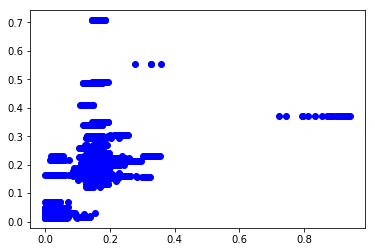

In [101]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(TEST_PREDICTION.flatten(), TEST_Y.flatten(), 'bo' )

In [102]:
# Test MSE
skmet.regression.mean_squared_error(TEST_PREDICTION.flatten(), TEST_Y.flatten() )

0.013671385468678446